In [1]:
import os
import os.path
import glob
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                              
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as colormap

import numpy as np
np.random.seed(1)

from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

Using TensorFlow backend.


In [2]:
imagedir = "Datasets/ByFamilyImagesWidth"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:         allaple	Number of images: 362
Label: 1	Family:           alman	Number of images: 325
Label: 2	Family:          autoit	Number of images: 261
Label: 3	Family:            daws	Number of images: 466
Label: 4	Family:            delf	Number of images: 359
Label: 5	Family:         gamarue	Number of images: 259
Label: 6	Family:          ibryte	Number of images: 347
Label: 7	Family:          loring	Number of images: 285
Label: 8	Family:          mydoom	Number of images: 578
Label: 9	Family:          qukart	Number of images: 253
Label:10	Family:          ramnit	Number of images: 506
Label:11	Family:          sality	Number of images: 1401
Label:12	Family:          simbot	Number of images: 1148
Label:13	Family:       softpulse	Number of images: 912
Label:14	Family:          viking	Number of images: 183
Label:15	Family:         virlock	Number of images: 373
Label:16	Family:          vobfus	Number of images: 405
Label:17	Family:          wapomi	Number of images: 345
Label:18

In [4]:
X.shape

(10136, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [7]:
# Training the model from scratch
num_epochs=100
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
history = []
checkpointer = ModelCheckpoint(filepath='weights-virussign-inceptionv3-Adam-%depochs-fromscratch.h5' %(num_epochs), monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=True, mode='auto')
callbacks_list = [checkpointer]
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix

model = InceptionV3(weights=None, input_shape=image_shape, include_top=True, classes=num_classes)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
init_weights = model.get_weights()

for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]
    
    model.set_weights(init_weights)

    start = time.time()
    h = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=64, verbose=1, callbacks=callbacks_list)
    end = time.time()
    history.append(h)
    
    y_prob = model.predict(X_test, verbose=1)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

Train on 9112 samples, validate on 1024 samples
Epoch 1/100
9112/9112 [==============================] - 90s - loss: 1.3235 - acc: 0.6308 - val_loss: 7.0213 - val_acc: 0.0000e+00
Epoch 2/100
9112/9112 [==============================] - 71s - loss: 0.8678 - acc: 0.7621 - val_loss: 13.7026 - val_acc: 0.1133
Epoch 3/100
9112/9112 [==============================] - 72s - loss: 0.5934 - acc: 0.8179 - val_loss: 3.2919 - val_acc: 0.4199
Epoch 4/100
9112/9112 [==============================] - 72s - loss: 0.4506 - acc: 0.8633 - val_loss: 2.1567 - val_acc: 0.6289
Epoch 5/100
9112/9112 [==============================] - 71s - loss: 0.6291 - acc: 0.8210 - val_loss: 16.0867 - val_acc: 0.0020
Epoch 6/100
9112/9112 [==============================] - 73s - loss: 0.8019 - acc: 0.7919 - val_loss: 4.0299 - val_acc: 0.3984
Epoch 7/100
9112/9112 [==============================] - 73s - loss: 0.4461 - acc: 0.8664 - val_loss: 0.8194 - val_acc: 0.7588
Epoch 8/100
9112/9112 [==============================] - 

9112/9112 [==============================] - 73s - loss: 0.0239 - acc: 0.9930 - val_loss: 1.4870 - val_acc: 0.7881
Epoch 65/100
9112/9112 [==============================] - 72s - loss: 0.0254 - acc: 0.9930 - val_loss: 1.4594 - val_acc: 0.7441
Epoch 66/100
9112/9112 [==============================] - 74s - loss: 0.0111 - acc: 0.9967 - val_loss: 0.4510 - val_acc: 0.9287
Epoch 67/100
9112/9112 [==============================] - 73s - loss: 0.0290 - acc: 0.9903 - val_loss: 0.6962 - val_acc: 0.8398
Epoch 68/100
9112/9112 [==============================] - 73s - loss: 0.0214 - acc: 0.9933 - val_loss: 1.0118 - val_acc: 0.8574
Epoch 69/100
9112/9112 [==============================] - 73s - loss: 0.0242 - acc: 0.9925 - val_loss: 0.5598 - val_acc: 0.8916
Epoch 70/100
9112/9112 [==============================] - 73s - loss: 0.0314 - acc: 0.9895 - val_loss: 4.1260 - val_acc: 0.4678
Epoch 71/100
9112/9112 [==============================] - 73s - loss: 0.0505 - acc: 0.9853 - val_loss: 1.3348 - val_a

9114/9114 [==============================] - 73s - loss: 0.1588 - acc: 0.9504 - val_loss: 1.5840 - val_acc: 0.6419
Epoch 28/100
9114/9114 [==============================] - 73s - loss: 0.1220 - acc: 0.9602 - val_loss: 0.7352 - val_acc: 0.8209
Epoch 29/100
9114/9114 [==============================] - 73s - loss: 0.1033 - acc: 0.9683 - val_loss: 0.4815 - val_acc: 0.8943
Epoch 30/100
9114/9114 [==============================] - 73s - loss: 0.0758 - acc: 0.9756 - val_loss: 0.6959 - val_acc: 0.8669
Epoch 31/100
9114/9114 [==============================] - 72s - loss: 0.0827 - acc: 0.9736 - val_loss: 1.0742 - val_acc: 0.7436
Epoch 32/100
9114/9114 [==============================] - 73s - loss: 0.1710 - acc: 0.9487 - val_loss: 0.5358 - val_acc: 0.8796
Epoch 33/100
9114/9114 [==============================] - 73s - loss: 0.0869 - acc: 0.9709 - val_loss: 0.5827 - val_acc: 0.8689
Epoch 34/100
9114/9114 [==============================] - 73s - loss: 0.0696 - acc: 0.9767 - val_loss: 0.5563 - val_a

9114/9114 [==============================] - 73s - loss: 0.0093 - acc: 0.9976 - val_loss: 0.5521 - val_acc: 0.9012
Epoch 92/100
9114/9114 [==============================] - 73s - loss: 0.0117 - acc: 0.9981 - val_loss: 0.8610 - val_acc: 0.8650
Epoch 93/100
9114/9114 [==============================] - 73s - loss: 0.0632 - acc: 0.9828 - val_loss: 0.5812 - val_acc: 0.9041
Epoch 94/100
9114/9114 [==============================] - 73s - loss: 0.0256 - acc: 0.9924 - val_loss: 2.0199 - val_acc: 0.7319
Epoch 95/100
9114/9114 [==============================] - 73s - loss: 0.0185 - acc: 0.9955 - val_loss: 1.2017 - val_acc: 0.7808
Epoch 96/100
9114/9114 [==============================] - 73s - loss: 0.0157 - acc: 0.9952 - val_loss: 0.6766 - val_acc: 0.8787
Epoch 97/100
9114/9114 [==============================] - 73s - loss: 0.0076 - acc: 0.9979 - val_loss: 0.5458 - val_acc: 0.9119
Epoch 98/100
9114/9114 [==============================] - 73s - loss: 0.0077 - acc: 0.9981 - val_loss: 0.5652 - val_a

9116/9116 [==============================] - 73s - loss: 0.0506 - acc: 0.9860 - val_loss: 0.5365 - val_acc: 0.8941
Epoch 55/100
9116/9116 [==============================] - 72s - loss: 0.0327 - acc: 0.9897 - val_loss: 1.4952 - val_acc: 0.7735
Epoch 56/100
9116/9116 [==============================] - 73s - loss: 0.0326 - acc: 0.9899 - val_loss: 0.5570 - val_acc: 0.9000
Epoch 57/100
9116/9116 [==============================] - 73s - loss: 0.0472 - acc: 0.9846 - val_loss: 0.6296 - val_acc: 0.8892
Epoch 58/100
9116/9116 [==============================] - 73s - loss: 0.0221 - acc: 0.9919 - val_loss: 2.1299 - val_acc: 0.7147
Epoch 59/100
9116/9116 [==============================] - 73s - loss: 0.0253 - acc: 0.9924 - val_loss: 1.1196 - val_acc: 0.8382
Epoch 60/100
9116/9116 [==============================] - 73s - loss: 0.2470 - acc: 0.9586 - val_loss: 7.1253 - val_acc: 0.1873
Epoch 61/100
9116/9116 [==============================] - 73s - loss: 0.9400 - acc: 0.7825 - val_loss: 4.2670 - val_a

9120/9120 [==============================] - 73s - loss: 1.3493 - acc: 0.6606 - val_loss: 2.6594 - val_acc: 0.3484
Epoch 18/100
9120/9120 [==============================] - 73s - loss: 1.2647 - acc: 0.6780 - val_loss: 5.1937 - val_acc: 0.1742
Epoch 19/100
9120/9120 [==============================] - 73s - loss: 1.0995 - acc: 0.7281 - val_loss: 1.9006 - val_acc: 0.4862
Epoch 20/100
9120/9120 [==============================] - 73s - loss: 0.7295 - acc: 0.7945 - val_loss: 0.8323 - val_acc: 0.7687
Epoch 21/100
9120/9120 [==============================] - 73s - loss: 0.5961 - acc: 0.8223 - val_loss: 0.8241 - val_acc: 0.7953
Epoch 22/100
9120/9120 [==============================] - 73s - loss: 0.5330 - acc: 0.8367 - val_loss: 0.7031 - val_acc: 0.8130
Epoch 23/100
9120/9120 [==============================] - 73s - loss: 0.4874 - acc: 0.8458 - val_loss: 0.6672 - val_acc: 0.8169
Epoch 24/100
9120/9120 [==============================] - 73s - loss: 0.4557 - acc: 0.8549 - val_loss: 0.6923 - val_a

9120/9120 [==============================] - 73s - loss: 0.0358 - acc: 0.9880 - val_loss: 1.0763 - val_acc: 0.7992
Epoch 82/100
9120/9120 [==============================] - 73s - loss: 0.0525 - acc: 0.9823 - val_loss: 1.7015 - val_acc: 0.7047
Epoch 83/100
9120/9120 [==============================] - 73s - loss: 0.0347 - acc: 0.9885 - val_loss: 0.8320 - val_acc: 0.8819
Epoch 84/100
9120/9120 [==============================] - 73s - loss: 0.0301 - acc: 0.9907 - val_loss: 1.0711 - val_acc: 0.8346
Epoch 85/100
9120/9120 [==============================] - 73s - loss: 0.0221 - acc: 0.9924 - val_loss: 0.8599 - val_acc: 0.8819
Epoch 86/100
9120/9120 [==============================] - 73s - loss: 0.0242 - acc: 0.9924 - val_loss: 0.8890 - val_acc: 0.8740
Epoch 87/100
9120/9120 [==============================] - 73s - loss: 0.0247 - acc: 0.9921 - val_loss: 0.9950 - val_acc: 0.8012
Epoch 88/100
9120/9120 [==============================] - 73s - loss: 0.0194 - acc: 0.9936 - val_loss: 0.8352 - val_a

9120/9120 [==============================] - 73s - loss: 0.1757 - acc: 0.9407 - val_loss: 0.4206 - val_acc: 0.9016
Epoch 45/100
9120/9120 [==============================] - 73s - loss: 0.1747 - acc: 0.9400 - val_loss: 0.4676 - val_acc: 0.8799
Epoch 46/100
9120/9120 [==============================] - 73s - loss: 0.1408 - acc: 0.9503 - val_loss: 0.4762 - val_acc: 0.8907
Epoch 47/100
9120/9120 [==============================] - 73s - loss: 0.1398 - acc: 0.9512 - val_loss: 0.4104 - val_acc: 0.9055
Epoch 48/100
9120/9120 [==============================] - 73s - loss: 0.1187 - acc: 0.9613 - val_loss: 0.4823 - val_acc: 0.8947
Epoch 49/100
9120/9120 [==============================] - 73s - loss: 0.1212 - acc: 0.9568 - val_loss: 0.4420 - val_acc: 0.9006
Epoch 50/100
9120/9120 [==============================] - 72s - loss: 0.1097 - acc: 0.9615 - val_loss: 0.4891 - val_acc: 0.8829
Epoch 51/100
9120/9120 [==============================] - 73s - loss: 0.1110 - acc: 0.9609 - val_loss: 0.4775 - val_a

9125/9125 [==============================] - 73s - loss: 0.9205 - acc: 0.7725 - val_loss: 7.7825 - val_acc: 0.0376
Epoch 8/100
9125/9125 [==============================] - 73s - loss: 1.8131 - acc: 0.5619 - val_loss: 13.5523 - val_acc: 0.1197
Epoch 9/100
9125/9125 [==============================] - 73s - loss: 1.4622 - acc: 0.6540 - val_loss: 13.9659 - val_acc: 0.0465
Epoch 10/100
9125/9125 [==============================] - 73s - loss: 1.2027 - acc: 0.7054 - val_loss: 6.2162 - val_acc: 0.1691
Epoch 11/100
9125/9125 [==============================] - 73s - loss: 0.9786 - acc: 0.7326 - val_loss: 1.5832 - val_acc: 0.6855
Epoch 12/100
9125/9125 [==============================] - 73s - loss: 0.7923 - acc: 0.7726 - val_loss: 0.7846 - val_acc: 0.7755
Epoch 13/100
9125/9125 [==============================] - 73s - loss: 0.7266 - acc: 0.7921 - val_loss: 2.4029 - val_acc: 0.5678
Epoch 14/100
9125/9125 [==============================] - 72s - loss: 0.8333 - acc: 0.7802 - val_loss: 0.6305 - val_a

9125/9125 [==============================] - 73s - loss: 0.0414 - acc: 0.9860 - val_loss: 0.6823 - val_acc: 0.8823
Epoch 72/100
9125/9125 [==============================] - 73s - loss: 0.0507 - acc: 0.9839 - val_loss: 0.9706 - val_acc: 0.8180
Epoch 73/100
9125/9125 [==============================] - 73s - loss: 0.0641 - acc: 0.9763 - val_loss: 0.7753 - val_acc: 0.8665
Epoch 74/100
9125/9125 [==============================] - 73s - loss: 0.0304 - acc: 0.9908 - val_loss: 0.7501 - val_acc: 0.8853
Epoch 75/100
9125/9125 [==============================] - 73s - loss: 0.0245 - acc: 0.9920 - val_loss: 0.6716 - val_acc: 0.8912
Epoch 76/100
9125/9125 [==============================] - 72s - loss: 0.0377 - acc: 0.9859 - val_loss: 1.8697 - val_acc: 0.7349
Epoch 77/100
9125/9125 [==============================] - 72s - loss: 0.0530 - acc: 0.9829 - val_loss: 2.1361 - val_acc: 0.7072
Epoch 78/100
9125/9125 [==============================] - 72s - loss: 0.0289 - acc: 0.9904 - val_loss: 0.6252 - val_a

9127/9127 [==============================] - 72s - loss: 1.0682 - acc: 0.7768 - val_loss: 1.9962 - val_acc: 0.5768
Epoch 35/100
9127/9127 [==============================] - 73s - loss: 0.6219 - acc: 0.8336 - val_loss: 0.5131 - val_acc: 0.8563
Epoch 36/100
9127/9127 [==============================] - 73s - loss: 0.3518 - acc: 0.8851 - val_loss: 0.6362 - val_acc: 0.7671
Epoch 37/100
9127/9127 [==============================] - 73s - loss: 0.3021 - acc: 0.9025 - val_loss: 0.3470 - val_acc: 0.8999
Epoch 38/100
9127/9127 [==============================] - 73s - loss: 0.2645 - acc: 0.9126 - val_loss: 0.3363 - val_acc: 0.9039
Epoch 39/100
9127/9127 [==============================] - 73s - loss: 0.2474 - acc: 0.9160 - val_loss: 0.3381 - val_acc: 0.9058
Epoch 40/100
9127/9127 [==============================] - 73s - loss: 0.2131 - acc: 0.9280 - val_loss: 0.3200 - val_acc: 0.9088
Epoch 41/100
9127/9127 [==============================] - 73s - loss: 0.2017 - acc: 0.9312 - val_loss: 0.3167 - val_a

9127/9127 [==============================] - 72s - loss: 0.0243 - acc: 0.9917 - val_loss: 0.4317 - val_acc: 0.9257
Epoch 99/100
9127/9127 [==============================] - 73s - loss: 0.0160 - acc: 0.9952 - val_loss: 5.4189 - val_acc: 0.5094
Epoch 100/100
1009/1009 [==============================] - 3s     
[6] Test acurracy: 0.9197 (7327.4661 s)
Train on 9128 samples, validate on 1008 samples
Epoch 1/100
9128/9128 [==============================] - 74s - loss: 1.8845 - acc: 0.4443 - val_loss: 13.1475 - val_acc: 0.1389
Epoch 2/100
9128/9128 [==============================] - 73s - loss: 1.0256 - acc: 0.6902 - val_loss: 3.6813 - val_acc: 0.3026
Epoch 3/100
9128/9128 [==============================] - 72s - loss: 0.7656 - acc: 0.7619 - val_loss: 3.8462 - val_acc: 0.2103
Epoch 4/100
9128/9128 [==============================] - 73s - loss: 0.6681 - acc: 0.7912 - val_loss: 2.2813 - val_acc: 0.4683
Epoch 5/100
9128/9128 [==============================] - 73s - loss: 0.5299 - acc: 0.8374 - v

9128/9128 [==============================] - 73s - loss: 0.0125 - acc: 0.9968 - val_loss: 3.2228 - val_acc: 0.5655
Epoch 62/100
9128/9128 [==============================] - 73s - loss: 0.0219 - acc: 0.9928 - val_loss: 2.9516 - val_acc: 0.5605
Epoch 63/100
9128/9128 [==============================] - 72s - loss: 0.0292 - acc: 0.9899 - val_loss: 2.8041 - val_acc: 0.6627
Epoch 64/100
9128/9128 [==============================] - 73s - loss: 0.0198 - acc: 0.9929 - val_loss: 1.6239 - val_acc: 0.7321
Epoch 65/100
9128/9128 [==============================] - 73s - loss: 0.0188 - acc: 0.9940 - val_loss: 3.1481 - val_acc: 0.6369
Epoch 66/100
9128/9128 [==============================] - 73s - loss: 0.0485 - acc: 0.9859 - val_loss: 3.3027 - val_acc: 0.5734
Epoch 67/100
9128/9128 [==============================] - 73s - loss: 0.0270 - acc: 0.9908 - val_loss: 3.5847 - val_acc: 0.6349
Epoch 68/100
9128/9128 [==============================] - 73s - loss: 0.0234 - acc: 0.9917 - val_loss: 5.3626 - val_a

9130/9130 [==============================] - 73s - loss: 0.1750 - acc: 0.9455 - val_loss: 4.5605 - val_acc: 0.4662
Epoch 25/100
9130/9130 [==============================] - 73s - loss: 0.1767 - acc: 0.9459 - val_loss: 0.8100 - val_acc: 0.7833
Epoch 26/100
9130/9130 [==============================] - 73s - loss: 0.1577 - acc: 0.9508 - val_loss: 0.6410 - val_acc: 0.8658
Epoch 27/100
9130/9130 [==============================] - 73s - loss: 0.1313 - acc: 0.9562 - val_loss: 0.9030 - val_acc: 0.8241
Epoch 28/100
9130/9130 [==============================] - 72s - loss: 0.1328 - acc: 0.9590 - val_loss: 0.8807 - val_acc: 0.8260
Epoch 29/100
9130/9130 [==============================] - 73s - loss: 0.1142 - acc: 0.9627 - val_loss: 5.7205 - val_acc: 0.4225
Epoch 30/100
9130/9130 [==============================] - 72s - loss: 0.1166 - acc: 0.9647 - val_loss: 1.4771 - val_acc: 0.6769
Epoch 31/100
9130/9130 [==============================] - 73s - loss: 0.1118 - acc: 0.9664 - val_loss: 4.1588 - val_a

9130/9130 [==============================] - 72s - loss: 0.0254 - acc: 0.9923 - val_loss: 3.3235 - val_acc: 0.5557
Epoch 89/100
9130/9130 [==============================] - 73s - loss: 0.0413 - acc: 0.9885 - val_loss: 1.0377 - val_acc: 0.8171
Epoch 90/100
9130/9130 [==============================] - 72s - loss: 0.0177 - acc: 0.9947 - val_loss: 1.3806 - val_acc: 0.7594
Epoch 91/100
9130/9130 [==============================] - 72s - loss: 0.0124 - acc: 0.9968 - val_loss: 2.5849 - val_acc: 0.6889
Epoch 92/100
9130/9130 [==============================] - 72s - loss: 0.0056 - acc: 0.9981 - val_loss: 0.7789 - val_acc: 0.9046
Epoch 93/100
9130/9130 [==============================] - 72s - loss: 0.0106 - acc: 0.9969 - val_loss: 4.1160 - val_acc: 0.5577
Epoch 94/100
9130/9130 [==============================] - 73s - loss: 0.0204 - acc: 0.9931 - val_loss: 3.8416 - val_acc: 0.5656
Epoch 95/100
9130/9130 [==============================] - 72s - loss: 0.0235 - acc: 0.9928 - val_loss: 3.6086 - val_a

9132/9132 [==============================] - 72s - loss: 0.0834 - acc: 0.9759 - val_loss: 2.4871 - val_acc: 0.5199
Epoch 52/100
9132/9132 [==============================] - 72s - loss: 0.3185 - acc: 0.9185 - val_loss: 1.1840 - val_acc: 0.7629
Epoch 53/100
9132/9132 [==============================] - 72s - loss: 0.1048 - acc: 0.9681 - val_loss: 3.6151 - val_acc: 0.5627
Epoch 54/100
9132/9132 [==============================] - 72s - loss: 0.2073 - acc: 0.9497 - val_loss: 3.0024 - val_acc: 0.5667
Epoch 55/100
9132/9132 [==============================] - 72s - loss: 0.0485 - acc: 0.9864 - val_loss: 1.0083 - val_acc: 0.7918
Epoch 56/100
9132/9132 [==============================] - 72s - loss: 0.0280 - acc: 0.9919 - val_loss: 2.1820 - val_acc: 0.7002
Epoch 57/100
9132/9132 [==============================] - 72s - loss: 0.0197 - acc: 0.9944 - val_loss: 0.4019 - val_acc: 0.9193
Epoch 58/100
9132/9132 [==============================] - 72s - loss: 0.0178 - acc: 0.9955 - val_loss: 0.6343 - val_a

In [8]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.7082


In [9]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

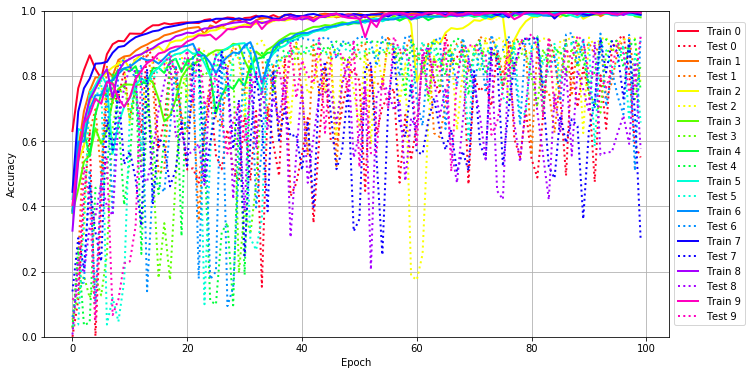

In [10]:
plot_acc(history)

In [11]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

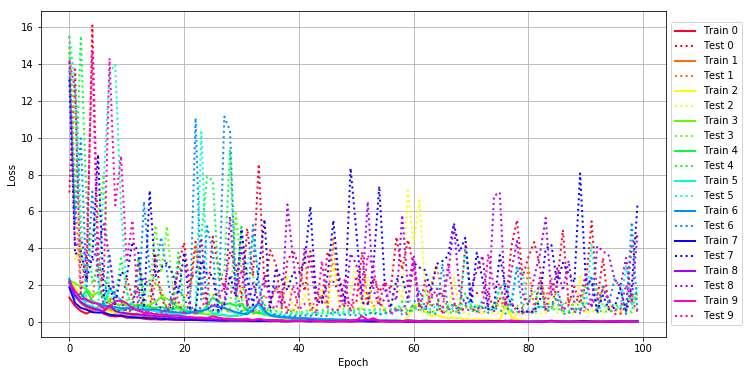

In [12]:
plot_loss(history)

Plotting the confusion matrix


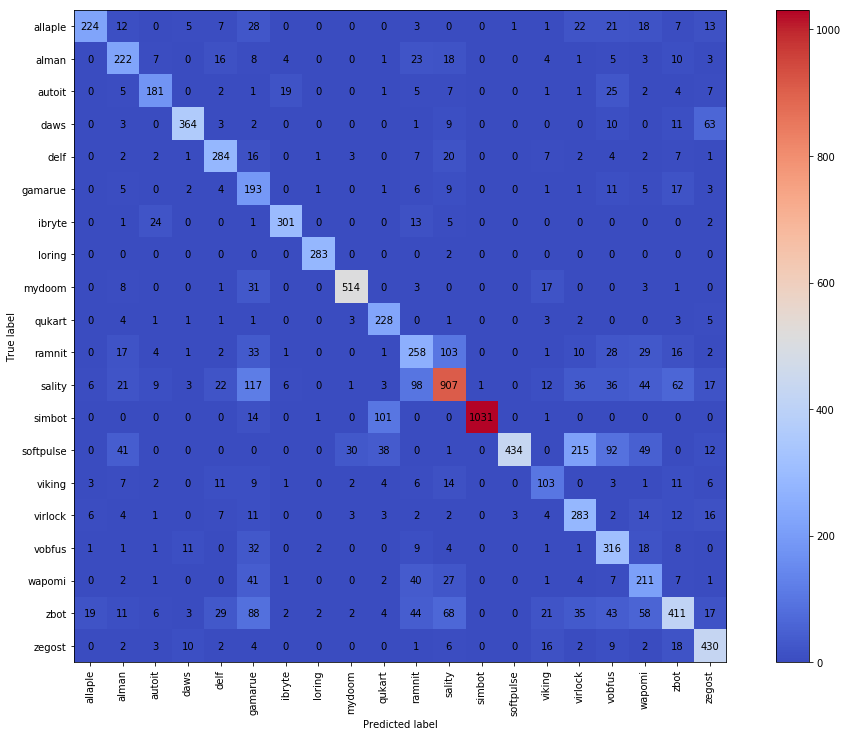

In [13]:
print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(18, 12)
plt.imshow(conf_mat,interpolation='nearest',cmap='coolwarm')
for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(int(conf_mat[row][col])),xy=(col,row),ha='center',va='center')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.show()

Plotting the confusion matrix normalized


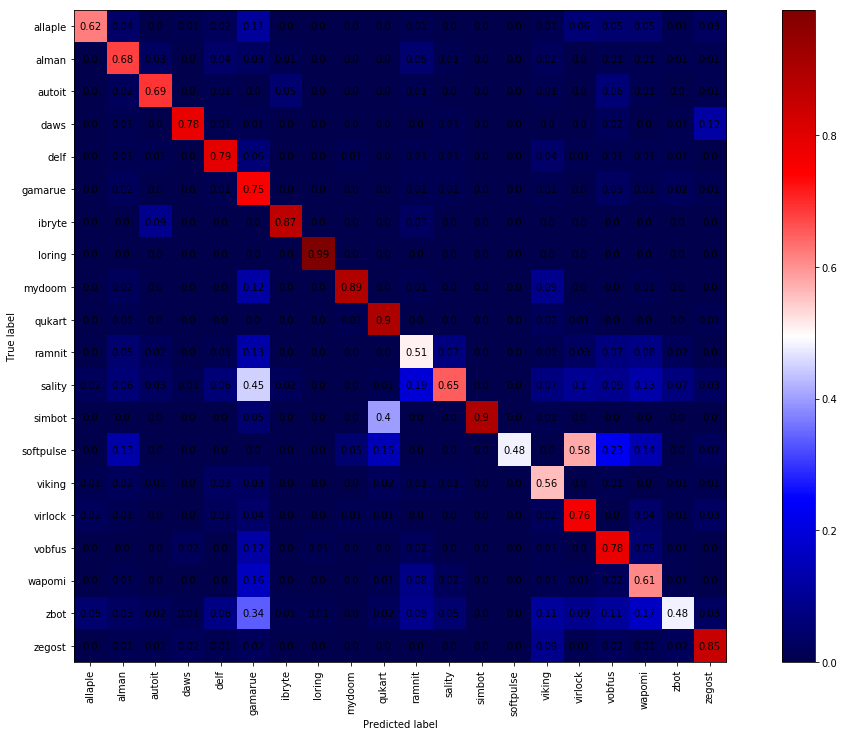

In [14]:
print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/no_imgs  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure
figure = plt.gcf()
figure.set_size_inches(20, 12)
plt.imshow(conf_mat_norm,interpolation='nearest',cmap='seismic')
for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(conf_mat_norm[row][col]),xy=(col,row),ha='center',va='center')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.show()

Plotting the confusion matrix normalized


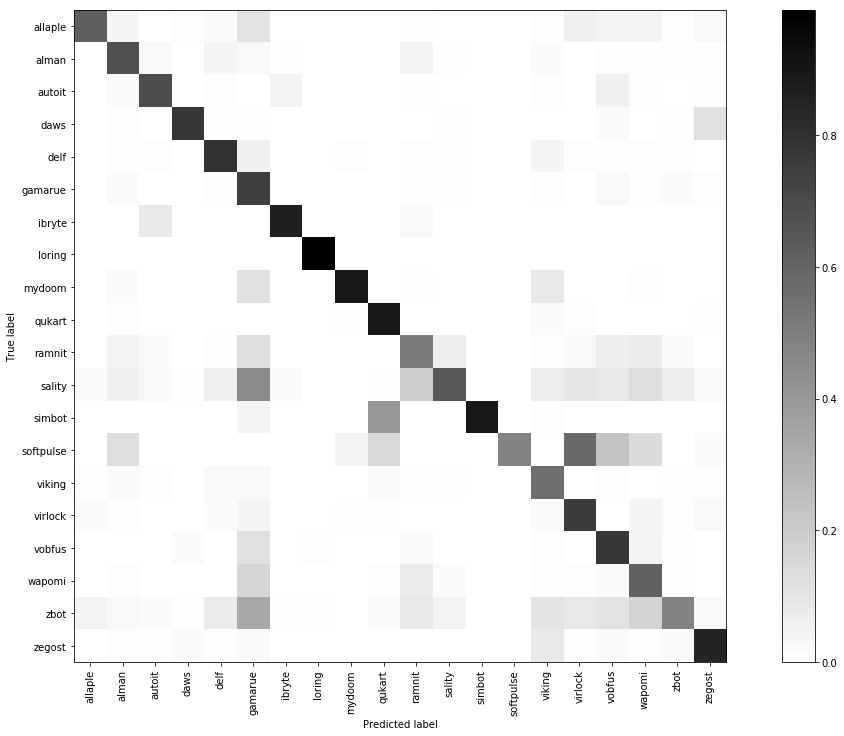

In [15]:
print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/no_imgs  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure
figure = plt.gcf()
figure.set_size_inches(20, 12)
plt.imshow(conf_mat_norm,interpolation='nearest',cmap='binary')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.show()

Plotting the confusion matrix normalized


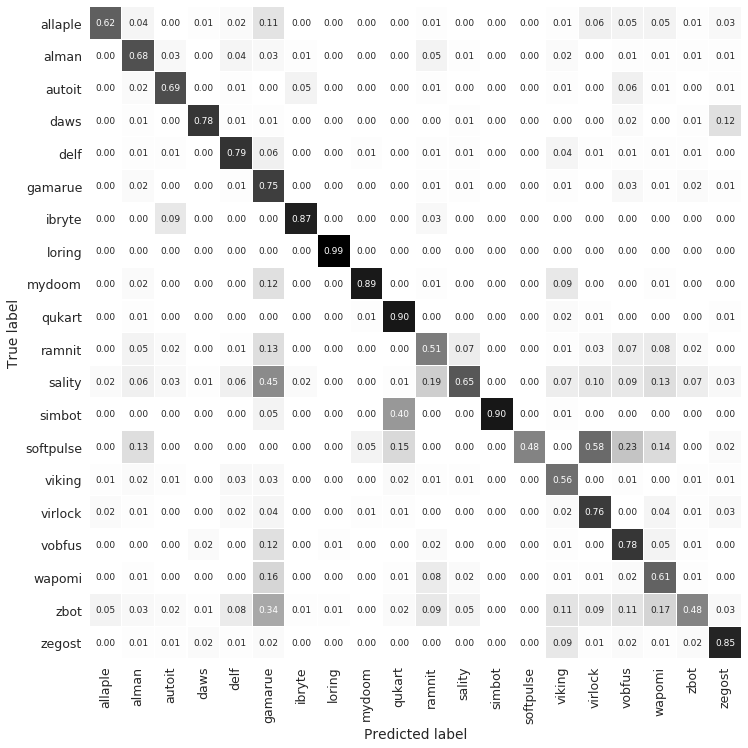

In [16]:
import seaborn as sns

print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1)  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure

figure = plt.gcf()
figure.set_size_inches(20, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 9}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [17]:
for h in history:
    print(h.history)

{'val_acc': [0.0, 0.11328125, 0.419921875, 0.62890625, 0.001953125, 0.3984375, 0.7587890625, 0.724609375, 0.732421875, 0.8154296875, 0.6689453125, 0.7626953125, 0.6220703125, 0.888671875, 0.8564453125, 0.5751953125, 0.662109375, 0.833984375, 0.8251953125, 0.65234375, 0.5126953125, 0.5166015625, 0.47265625, 0.625, 0.748046875, 0.556640625, 0.513671875, 0.6357421875, 0.5126953125, 0.4765625, 0.681640625, 0.478515625, 0.6923828125, 0.1533203125, 0.7060546875, 0.58984375, 0.4931640625, 0.8623046875, 0.431640625, 0.470703125, 0.560546875, 0.6708984375, 0.349609375, 0.6044921875, 0.8291015625, 0.603515625, 0.5859375, 0.701171875, 0.7900390625, 0.822265625, 0.7841796875, 0.447265625, 0.8271484375, 0.623046875, 0.705078125, 0.7373046875, 0.7607421875, 0.47265625, 0.6806640625, 0.5419921875, 0.65234375, 0.845703125, 0.8798828125, 0.7880859375, 0.744140625, 0.9287109375, 0.83984375, 0.857421875, 0.8916015625, 0.4677734375, 0.7958984375, 0.7529296875, 0.7744140625, 0.7080078125, 0.8740234375, 0.7

In [18]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0].history['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['acc']
    test_scores = np.zeros((len(history),len(history[0].history['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_acc']
    epochs = np.linspace(0, len(history[0].history['acc']), len(history[0].history['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.show()

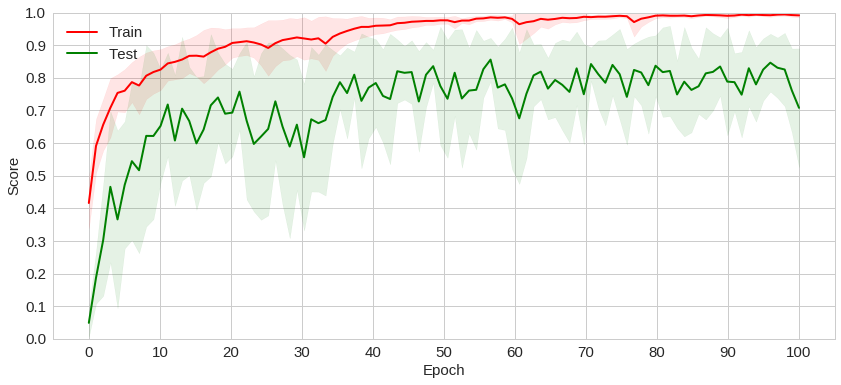

In [19]:
plot_mean_acc(history)

In [20]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0].history['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['loss']
    test_scores = np.zeros((len(history),len(history[0].history['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_loss']
    epochs = np.linspace(0, len(history[0].history['loss']), len(history[0].history['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    plt.show()

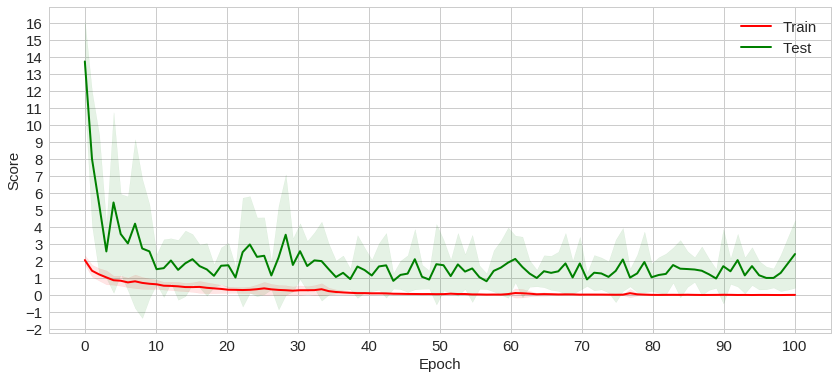

In [21]:
plot_mean_loss(history)

In [23]:
history = [{'val_acc': [0.0, 0.11328125, 0.419921875, 0.62890625, 0.001953125, 0.3984375, 0.7587890625, 0.724609375, 0.732421875, 0.8154296875, 0.6689453125, 0.7626953125, 0.6220703125, 0.888671875, 0.8564453125, 0.5751953125, 0.662109375, 0.833984375, 0.8251953125, 0.65234375, 0.5126953125, 0.5166015625, 0.47265625, 0.625, 0.748046875, 0.556640625, 0.513671875, 0.6357421875, 0.5126953125, 0.4765625, 0.681640625, 0.478515625, 0.6923828125, 0.1533203125, 0.7060546875, 0.58984375, 0.4931640625, 0.8623046875, 0.431640625, 0.470703125, 0.560546875, 0.6708984375, 0.349609375, 0.6044921875, 0.8291015625, 0.603515625, 0.5859375, 0.701171875, 0.7900390625, 0.822265625, 0.7841796875, 0.447265625, 0.8271484375, 0.623046875, 0.705078125, 0.7373046875, 0.7607421875, 0.47265625, 0.6806640625, 0.5419921875, 0.65234375, 0.845703125, 0.8798828125, 0.7880859375, 0.744140625, 0.9287109375, 0.83984375, 0.857421875, 0.8916015625, 0.4677734375, 0.7958984375, 0.7529296875, 0.7744140625, 0.7080078125, 0.8740234375, 0.7646484375, 0.904296875, 0.6064453125, 0.55078125, 0.6943359375, 0.544921875, 0.48828125, 0.677734375, 0.91796875, 0.853515625, 0.7333984375, 0.494140625, 0.83984375, 0.7041015625, 0.8251953125, 0.748046875, 0.474609375, 0.8017578125, 0.6376953125, 0.8876953125, 0.912109375, 0.923828125, 0.8134765625, 0.58984375, 0.5498046875], 'acc': [0.63081650581142168, 0.76207199308095641, 0.81793239683933272, 0.86325724319578578, 0.82100526788341466, 0.79192273924495171, 0.86643985952589986, 0.89705882358174249, 0.90726514496857713, 0.90605794567094755, 0.92976294995610187, 0.92921422310729529, 0.92910447761194026, 0.94402985085093005, 0.95500438981562774, 0.95533362598770855, 0.96158911330957386, 0.95818700619807251, 0.96093064091308167, 0.96323529416997777, 0.96411325734785713, 0.96279631260720333, 0.96191834953398536, 0.97124670763827914, 0.97388059701492535, 0.96224758560140478, 0.97355136084284455, 0.97892888498683051, 0.97750219501247526, 0.96938103610114956, 0.97739244956945093, 0.97881913959613698, 0.98474539069359091, 0.97618525021949076, 0.97914837576821778, 0.98628182626796246, 0.97870939420544334, 0.98496488147497807, 0.98891571553994728, 0.98287971905179983, 0.98255048287971902, 0.98222124670763833, 0.9769534679543459, 0.98792800712836637, 0.99056189640035119, 0.98847673397717295, 0.97936786665426623, 0.98584284460052674, 0.98880597014925375, 0.98759877095628557, 0.98507462697033299, 0.97958735733099211, 0.98847673408183434, 0.99034240572362542, 0.99275680431888436, 0.98924495181668948, 0.98957418788410889, 0.989354697207383, 0.98573309920983321, 0.99111062345848056, 0.99231782265144863, 0.99067164189570611, 0.98650131694468834, 0.99297629499561013, 0.99297629499561013, 0.99670763838385368, 0.99034240561896403, 0.99330553127235233, 0.9925373134328358, 0.98946444259807664, 0.98529411775172016, 0.9928665496049166, 0.99495171202809485, 0.9955004390862241, 0.99659789288849865, 0.99879280070237053, 0.99824407374890256, 0.98946444259807664, 0.98759877095628557, 0.9918788410886743, 0.99593942064899854, 0.99517120286181271, 0.98683055311676915, 0.99714661984196662, 0.99725636523266026, 0.99758560140474095, 0.99429323968393324, 0.98946444259807664, 0.99220807726075499, 0.99846356453028973, 0.99539069369553057, 0.99001316955154461, 0.98672080772607551, 0.99462247585601404, 0.99385425812115891, 0.99835381913959609, 0.99923178226514486, 0.99978050921861283, 0.99890254619772545, 0.99045215100965756], 'loss': [1.3234646260686043, 0.8677707034522133, 0.59340891181847, 0.4505679203921813, 0.62905343213135789, 0.80192668041291204, 0.44606785071953231, 0.33530321991998341, 0.30003184781355019, 0.32032309756454824, 0.23346222642747011, 0.22872619510115605, 0.23138287149310843, 0.17721706450875127, 0.14524733348438046, 0.14711817650613396, 0.12403797781498836, 0.13911635349516915, 0.12222226665382248, 0.11242133749222107, 0.10852142259203833, 0.11579056307215561, 0.11186296604671847, 0.092282890145118243, 0.084697689143147667, 0.1195400006467308, 0.084186765463831428, 0.069500204188793352, 0.076713041524231904, 0.098542555286839306, 0.07265239441971752, 0.06392641059720694, 0.048144292688165662, 0.07673275242768117, 0.071142256151986188, 0.038413147025032721, 0.066628376363765993, 0.048647872818252884, 0.034814754945795924, 0.056667667727744085, 0.053055076052854207, 0.058804641507199662, 0.071423790525543623, 0.038220108354249945, 0.030155404992021385, 0.035620302427151258, 0.063714771315658211, 0.045147176438662909, 0.030286869306045343, 0.037809228170924775, 0.050005441098175521, 0.069798708033173146, 0.035652790990878057, 0.030032587114290625, 0.023561214198439307, 0.033478175839809887, 0.028361782194070252, 0.029572031063725149, 0.046470192839948361, 0.030277407726500252, 0.024703215637192771, 0.029115096613996982, 0.045654960434157746, 0.0238836705551791, 0.025406094792497665, 0.011123492643711361, 0.028971472593994126, 0.021413488582005976, 0.024184162463973209, 0.031365950881214071, 0.050480790648247988, 0.02821878456045351, 0.017889533419997283, 0.013710172708932052, 0.013610135096258585, 0.0043467035760556836, 0.006236496996934811, 0.036117983047782562, 0.042377173856450234, 0.029000836789515604, 0.012103702477854044, 0.014129266590466665, 0.04775962702945509, 0.010946868406210088, 0.0074376953211831723, 0.0074027180439934443, 0.019162659698950504, 0.035936287134522744, 0.021895159702064081, 0.0069268765216977425, 0.016176410965233898, 0.029467301672268121, 0.043242685869663192, 0.015403725161369239, 0.022143452362970165, 0.0057924525926090044, 0.0035563131731577526, 0.0015978511653659019, 0.0043904736765548527, 0.032101512557294022], 'val_loss': [7.0212500393390656, 13.702569813933387, 3.2918562554987147, 2.1567131923511624, 16.086705088615417, 4.0299486592411995, 0.81942429800983518, 1.2345293584512547, 1.0376663692295551, 0.86833291027141968, 2.388561856783781, 1.2518250583088957, 1.8350641051256389, 0.45182730791930226, 0.61900554900057614, 3.6292724559316412, 1.2957295696251094, 0.70939056109637022, 0.84970275359228253, 3.1724569356301799, 4.30490638374431, 1.8538551144301891, 4.3473335802555084, 1.9386174278333783, 1.1171961303352873, 4.6333150793798268, 2.8763472586870193, 1.7730482127517462, 3.8042560713365674, 3.1471967380493879, 1.3225828344002366, 5.0704409374229726, 2.493481969460845, 8.5689742565155029, 1.8649663719843375, 3.8937479664418788, 3.1447383397025988, 0.74532406055368483, 3.319067754317075, 3.8922100905328989, 3.0333743922489589, 1.6759851457210004, 3.8414843268692493, 1.7891926890733885, 1.098323711194098, 3.8073798944668633, 3.0829884760917707, 2.5115360347554088, 1.1208144753691158, 1.0642549594776938, 1.02544321381788, 3.7920228186994791, 0.90723270569787928, 2.4014219604432583, 1.6396345049142838, 2.1643070427751923, 1.7596763579649917, 4.612977952696383, 2.8341443948447704, 4.4562163296413928, 3.0019070720736636, 0.72606472338611638, 0.64544320944696665, 1.4870123961597983, 1.4594273836232805, 0.45099071064964935, 0.69622505653114786, 1.01183333001552, 0.55976456549706199, 4.1259652599692345, 1.3348161433823407, 1.5665983774233609, 1.6103070022218162, 1.6209923231508583, 0.57828913406649463, 1.3356088466721019, 0.62955979532314643, 4.0401311299065128, 5.5259852155941189, 2.4829975546941228, 3.5294986488297582, 4.3326198970898986, 3.0347887063398957, 0.53415122228079781, 0.72936496855248123, 2.1358583511036855, 4.99689831584692, 1.0068256605300121, 1.9124320899136364, 1.0026473667514892, 2.0608318955637515, 5.4661859488396658, 1.2372477317861694, 3.475602877791971, 0.70080643402855003, 0.44074814497752612, 0.4425776551218803, 0.85945978504610032, 4.1394111998678156, 4.7288831137750549]},
{'val_acc': [0.028375733855185908, 0.23483365908294274, 0.62622308777736357, 0.629158511845333, 0.69765166037236637, 0.49608610334228398, 0.83072406975023905, 0.71135029307550179, 0.83953033023151169, 0.85420743220006412, 0.85225048585413954, 0.84735812063086524, 0.85029354044136007, 0.87573385261976089, 0.77690802091721689, 0.50097847288135444, 0.51272015527269843, 0.80919765003040112, 0.78375733458599228, 0.67906066186274106, 0.62720156112529057, 0.73972602739726023, 0.35616438402821637, 0.63600782627228891, 0.79549901802712453, 0.67123287542925425, 0.64187866904264324, 0.82093933393810592, 0.89432485159595887, 0.86692758852255092, 0.74363991822281927, 0.87964774694461412, 0.86888454035070306, 0.86399216871205609, 0.66438356141054933, 0.8375733821359399, 0.61154598755845824, 0.71819960686092044, 0.86692759120534313, 0.90215264012902219, 0.73874755136654102, 0.55772993884207922, 0.89530332331088192, 0.73972602529768372, 0.82191780402002501, 0.87671232620097417, 0.52348336384954286, 0.78375733505256484, 0.83659490843808348, 0.85029354137450519, 0.88747553559432057, 0.90019569028380331, 0.77690802185036201, 0.78082191524207012, 0.75929549458908707, 0.92172211000364124, 0.8708414856468395, 0.86888453568497748, 0.87769079791589721, 0.9236790571660678, 0.84735811876457501, 0.89236790256724197, 0.89823874405452186, 0.62426614306444295, 0.61252445880680872, 0.71232876549028368, 0.85420743196677784, 0.89921721950202538, 0.90410958740809189, 0.81506849455040264, 0.86301369793027816, 0.92074363548928273, 0.90606653363737344, 0.91487279668479515, 0.879647746011469, 0.80528375570554789, 0.87964774881090435, 0.91291584870586662, 0.90900195344786816, 0.88551858924839599, 0.55772994035844004, 0.89530332424402703, 0.75146770978860422, 0.75146770862217283, 0.62622308941036753, 0.79060665105420314, 0.91095889967714971, 0.73874755124989788, 0.90019569308323866, 0.87377690545733433, 0.9011741647981617, 0.86497064427620274, 0.90410958740809189, 0.73189823723119296, 0.780821914308925, 0.87866927336340084, 0.91193737419150811, 0.91585127038265157, 0.79843443923733703, 0.78962817898935067], 'acc': [0.38534123329366016, 0.5739521616667228, 0.69168312494132711, 0.75400482786834466, 0.7954794823116238, 0.79493087562835607, 0.8158876455900097, 0.79899056407216085, 0.84891375914356648, 0.85955672596849209, 0.86219003740988309, 0.8773315778054871, 0.88841342991424388, 0.89620364293053878, 0.90618828188203682, 0.91288128172799321, 0.9241825763478676, 0.92846170744666778, 0.93438665807207921, 0.94031160871057051, 0.94546851008927746, 0.94777265754163542, 0.9497476412011574, 0.92890059270433933, 0.95457537873470921, 0.94843098558510031, 0.95040596893070717, 0.96017116533184821, 0.96829054211481946, 0.97564186983420342, 0.97355716489296307, 0.94865042809621791, 0.97092385350389132, 0.9767390828345045, 0.97904323029994234, 0.96829054202326093, 0.978494623655914, 0.98628483651525123, 0.98891814799588162, 0.97487382049594029, 0.98365152512617948, 0.97366688620084096, 0.9733377221856484, 0.98727232837771173, 0.9885889840722476, 0.98672372174676326, 0.98025016476507898, 0.98332236138566276, 0.98727232828615319, 0.9884792627643697, 0.99067368883037088, 0.98496818091227401, 0.97630019768147136, 0.98452929558920343, 0.98441957446444261, 0.99089313153768543, 0.99583059048375355, 0.98902786921220098, 0.98452929558920343, 0.99045424630617351, 0.99297783638736725, 0.99177090190915074, 0.99396532806671056, 0.99692780337941633, 0.98507790222015201, 0.98266403344683617, 0.9927583936800527, 0.98441957437288408, 0.98716260697827518, 0.99264867255529188, 0.98979591845890558, 0.99188062321702875, 0.9946236559139785, 0.99703752468729423, 0.99429449199034448, 0.98957647585622932, 0.98782093491710177, 0.99341672161887917, 0.99572086908431701, 0.99440421348133967, 0.99396532806671056, 0.99242922975641867, 0.99286811498793071, 0.99824445907395221, 0.99264867237217469, 0.98935703313583501, 0.99561114768488035, 0.99308755769524526, 0.98606539399105386, 0.99363616414307654, 0.99758613122668427, 0.99813473785763274, 0.98277375466315553, 0.99242922984797732, 0.99550142646856099, 0.99517226245336843, 0.99791529524187683, 0.9981347377660742, 0.99791529515031818, 0.9964889181479043], 'loss': [2.1049549000446857, 1.4288824784904817, 1.0126820956245441, 0.78364669847624435, 0.659230038330747, 0.64795101200354477, 0.57573809952282817, 0.66812431403542649, 0.49383039452872934, 0.45438498906040758, 0.43941591645715422, 0.38263360223724102, 0.36677907226455558, 0.33321791824500291, 0.30416495332546289, 0.28058618571325589, 0.24639294638049322, 0.22608860206886527, 0.21193894980009748, 0.1850617309921479, 0.17571869070707299, 0.16254557587741, 0.15747332552009333, 0.23148308850339244, 0.14091607922390154, 0.16447682551498446, 0.15882622403993349, 0.1219980262149602, 0.1032740550231379, 0.075782050649822089, 0.08274025095445639, 0.17104187265401455, 0.086850833899035168, 0.069615111418766543, 0.063816729405744052, 0.10336806322524596, 0.068981982424237212, 0.045400019873253261, 0.035876252908167254, 0.078930080354308541, 0.05179511617549501, 0.090745979061259072, 0.082651609259569478, 0.041231810528313304, 0.037612797708359104, 0.045664229659716782, 0.058851927819679982, 0.051005292856329647, 0.040896106432466911, 0.036400269827338877, 0.031409576806017629, 0.04820097890997864, 0.076239394917936992, 0.048404597274882243, 0.042897347121325556, 0.029523065547089528, 0.01689382901978069, 0.03482905338361568, 0.050102213088407482, 0.032233924186603133, 0.025455621991241961, 0.025943197221081869, 0.019584960673724134, 0.011556925650707281, 0.053332663556679004, 0.053990348544080503, 0.022227630618125216, 0.047777434076585773, 0.040718466318556815, 0.027958493163518564, 0.029309796027770514, 0.027220382712344483, 0.020287342636874824, 0.012946050254526284, 0.033345290781373792, 0.036176283418721852, 0.04318889787893547, 0.024496026964057446, 0.015788044923144343, 0.021154948044670486, 0.0223913903656545, 0.025859136947172956, 0.023133354187637095, 0.0086966614278361602, 0.02552311076965148, 0.03295228217933012, 0.013785210225679224, 0.025933528983822864, 0.046575848983928955, 0.020816560766743673, 0.0092609125547491577, 0.011683248515244016, 0.063208107922265735, 0.025614138829853122, 0.01853820549517082, 0.015659080597624962, 0.0075886767890334167, 0.0077378350270149538, 0.0081936781698176125, 0.011503860374170954], 'val_loss': [15.480116297354204, 7.0179777835913137, 1.3434554165823351, 1.3268129219047711, 1.1750682077920538, 3.6661938825465463, 0.53821850557849826, 0.98987476795970109, 0.48229179012273854, 0.43733495497190322, 0.46570465565019392, 0.50544688187233389, 0.44089439543193742, 0.38344660876665099, 0.63793236962036615, 2.1412135418613829, 1.7891549810971299, 0.70739165986587393, 0.7706503223066461, 1.4344016518115763, 1.4703787272457041, 1.4178146126218971, 4.1147186233572768, 1.7693338964950958, 0.71620023055202575, 1.4483406065494813, 1.5839922449944737, 0.73521209283095812, 0.4814680339303779, 0.69594575039513407, 1.074230242673665, 0.53581684952740305, 0.58274958047668635, 0.55625788654417618, 1.4917320892535544, 0.97661667251540252, 1.8585503306057589, 1.4571277767769744, 0.71856258520510219, 0.51161164849442509, 1.5215725562604256, 3.7604043511154384, 0.53088679654822624, 1.3344910204293909, 1.4372471053947908, 0.77168123311055148, 4.5224944502466089, 1.0817374725864357, 0.90404140890927698, 0.85141845248592196, 0.73084017228327847, 0.65745446463744295, 1.5586017101871874, 0.8367703647175968, 1.2691295104959721, 0.46799122975530799, 0.68581317420221899, 0.67879913535963288, 0.60749450501614044, 0.46209617358680344, 0.7802773946112499, 0.63062733402585069, 0.55230245915867693, 1.9037494554429055, 3.1042793863288942, 1.4279099555354413, 0.74527406031335341, 0.58625435929688996, 0.50636905103961982, 0.83056447640427711, 0.87917574245000618, 0.53566556340379934, 0.51096399661333303, 0.66126928151474218, 0.75144700967358635, 1.263445016930751, 0.66283330477088642, 0.51643626196966042, 0.51102997438465891, 0.60527023596640783, 2.9502658200124006, 0.6811977278608865, 2.2524804244885939, 1.295782314910594, 2.3564439600318989, 1.0285784964547067, 0.61700359883548872, 1.3796923308261468, 0.66083980910798967, 0.73285729221228701, 0.55208050524132324, 0.8610372710929739, 0.58123495819082061, 2.0199244622771726, 1.2017449648962153, 0.67655095019813727, 0.54584291673302787, 0.56521776138847124, 1.3416042660699679, 1.494484642713737]},
{'val_acc': [0.024509803921568627, 0.25000000140246226, 0.30980392180237115, 0.7509803963642494, 0.76470588749530266, 0.77156863259334185, 0.69705882680182363, 0.765686276847241, 0.84019608076880958, 0.83333333754072003, 0.64705882773679846, 0.78823529739005893, 0.78137255112330117, 0.70392157143237544, 0.8529411797430001, 0.85000000303866818, 0.82254902264651131, 0.87058823763155468, 0.864705885625353, 0.86666667227651562, 0.71666667180902821, 0.88137255205827603, 0.88529411998449592, 0.87549020262325516, 0.86470588539160931, 0.86666667064030967, 0.87647059220893708, 0.85098039472804354, 0.88529412325690771, 0.85000000397364295, 0.67254902288025498, 0.88431373110004496, 0.89607843698239797, 0.90784314192977611, 0.87549020168828029, 0.88039215990141328, 0.85392157260109391, 0.81666667321149045, 0.65588235527861349, 0.89901961438796096, 0.85882353245043286, 0.74607843441121724, 0.765686276847241, 0.86862745752521586, 0.74607843370998606, 0.86666666806912884, 0.61372549346849026, 0.85882353408663881, 0.84313726051180971, 0.75686274743547621, 0.64117647339315975, 0.880392162472594, 0.58921568861194684, 0.89411765103246654, 0.77352941597209257, 0.90000000654482371, 0.88921569024815283, 0.71470588656032785, 0.83823529622134041, 0.18725490231139988, 0.17450980402383151, 0.25294117699651159, 0.65588235597984468, 0.85980392297108965, 0.82058823669657988, 0.86666667227651562, 0.88529412419188258, 0.63431373063255758, 0.81078431769913317, 0.88235294257893282, 0.89411765266867249, 0.81274510037665271, 0.91568627918467804, 0.8421568641475603, 0.91960784968207865, 0.90882353338540767, 0.71862745495403513, 0.88529412162070176, 0.89411764846128572, 0.86470588632658418, 0.87352941737455481, 0.90196079085854919, 0.91470588889776494, 0.91274510201285863, 0.69705882586684886, 0.90882353595658849, 0.90882353081422695, 0.91764706536835317, 0.92058823926776068, 0.62450980859644267, 0.91764706279717234, 0.89215686508253511, 0.91274510201285863, 0.91764706279717234, 0.8745098078952116, 0.90098039613050573, 0.91176471242717672, 0.91274510458403946, 0.91470588632658412, 0.77843137441896926], 'acc': [0.40302764378184025, 0.53773584908275762, 0.5851250549532333, 0.71709082938956292, 0.76020184296586635, 0.7900394910832883, 0.81164984650233174, 0.82634927605055253, 0.83666081640897172, 0.85004387899886735, 0.82130320323774197, 0.85048266783677051, 0.86573058369390898, 0.88021061879702434, 0.88075910507978816, 0.8905221590508281, 0.87242211511962608, 0.90171127700659204, 0.90785432212339157, 0.908622202798953, 0.91970162354524121, 0.92090829311101363, 0.92924528317579103, 0.92781921916491317, 0.93867924543994197, 0.93999561221519023, 0.94866169372531817, 0.94317683199614277, 0.94855199669891932, 0.95118473019710803, 0.95743747268030654, 0.95513383067977586, 0.96017990346643267, 0.9659938570594202, 0.96028960078052383, 0.96895568231680562, 0.9714787187885956, 0.96939447131163203, 0.97323387450636245, 0.97871873634015327, 0.97795085569074558, 0.97444054415059644, 0.97389205792014044, 0.98310662581764752, 0.97926722251830156, 0.98080298376480912, 0.98277753405845081, 0.98332602018429138, 0.98354541465555068, 0.98146116723089483, 0.98859148754682291, 0.98420359827855952, 0.98047389211022784, 0.98595875383940323, 0.9896884599554272, 0.9899078544266865, 0.98464238701184725, 0.99188240456340504, 0.99243089074155333, 0.95864414229838668, 0.78247038179868766, 0.82075471703343983, 0.86594997821747599, 0.91081614759000784, 0.89732338760755936, 0.93242650295674356, 0.94657744630066221, 0.94350592385995491, 0.94591926288688433, 0.95688898644985054, 0.97082053542712532, 0.96862659060991663, 0.977182975041338, 0.97323387455867016, 0.98321632300096939, 0.98211935064467282, 0.83830627483880116, 0.91070645040668585, 0.94438350161422291, 0.96709082936340907, 0.97981570864414214, 0.98179025893778382, 0.98705572619569992, 0.98903027643703378, 0.99133391838525664, 0.98069328658148713, 0.99254058797718292, 0.99396665209267632, 0.99517332163229488, 0.97498903027643702, 0.98420359806932867, 0.99199210179903463, 0.99616059675296187, 0.99462483545414659, 0.99374725756910931, 0.99111452391399735, 0.99056603773584906, 0.9888108820180822, 0.99341816586222031, 0.99363756038578732], 'loss': [2.2481863977826442, 1.8623300416786559, 1.492026843643858, 0.93275003984550886, 0.79362198607133849, 0.68469611402664754, 0.60226591567608179, 0.57389936145328024, 0.51937194961683431, 0.47944955336205425, 0.57380951880205611, 0.47612815896582844, 0.42263091425196858, 0.38614771045996149, 0.36905012953537708, 0.34333486507837579, 0.4009491589154105, 0.30695932420945682, 0.28449779886878235, 0.27817652716140778, 0.24287253639163445, 0.23925160958271061, 0.22172699892871367, 0.21947041340907869, 0.18727292697803133, 0.18025937478314266, 0.1542958455849251, 0.16321617436806535, 0.14592341548416268, 0.1478249248821728, 0.12312887304312517, 0.12429696974680056, 0.11812244775693188, 0.096233029358216468, 0.12283814840015481, 0.091150303352043896, 0.089648624485707581, 0.088801609657086944, 0.081560698097973033, 0.064226163795586474, 0.068545872668403451, 0.078268576197623688, 0.070363013815917738, 0.050575714141535832, 0.058753423546426597, 0.057563927542367568, 0.051918970369466202, 0.048232188854512019, 0.051029856231336587, 0.057357522413402653, 0.035313749946604807, 0.054357663089570483, 0.062848167063218038, 0.050566844762306613, 0.032691017085030027, 0.032591342020448021, 0.047184679382196663, 0.022146723630375093, 0.02529548544611597, 0.24702317155113002, 0.93999151997317243, 0.87068019346376946, 0.57871856282499079, 0.31604189460033805, 0.37944608170926547, 0.26540574674650264, 0.21297970462219398, 0.23845221926738108, 0.2117804358956478, 0.15600689372089466, 0.11142309924760059, 0.14094364502560797, 0.1207925531360966, 0.12943658962381571, 0.093115614600456711, 0.098049215161653921, 0.86230837564936669, 0.27909296455483734, 0.16137826552564713, 0.095458974462687418, 0.056557798204831568, 0.057417471107290001, 0.042971597204721254, 0.031887498966811742, 0.02974272116417161, 0.059737010703255808, 0.022289919803027733, 0.016853076599320921, 0.016084319581500386, 0.087330673670885775, 0.04904836001133725, 0.027616393304715596, 0.01379094953077039, 0.016289274998584589, 0.018555058416378809, 0.025953010498403442, 0.025932505587667565, 0.032959042801495156, 0.020127027927206838, 0.020659225285478252], 'val_loss': [14.690074943093693, 3.3492838083529004, 4.1295469097062663, 0.8679936266412922, 0.82799048961377608, 0.7548707142764447, 0.84982894764227024, 0.71954538553368808, 0.52895106938393677, 0.5344117214574533, 1.0277580371090018, 0.64108355115441717, 0.68219258598252841, 0.9487383761242324, 0.47599747402995241, 0.46574951939138709, 0.56345867906130997, 0.43025166215922905, 0.45823089492087271, 0.44393646478671217, 1.4171318603496925, 0.42619097652005067, 0.41004027006188953, 0.49519156559060018, 0.47368613429568418, 0.5767825876472189, 0.58004762481523719, 0.66882149816732206, 0.52407084958720263, 0.51301714336324378, 1.9454417331559086, 0.46312443512473622, 0.42820109640768567, 0.43184901898471162, 0.57067139698009861, 0.59007717495482859, 0.6847071122414633, 0.73759878717907013, 2.5314653298440475, 0.5250162264591256, 0.7294310311238994, 1.4535195401851453, 0.96956132175629117, 0.69364575911861137, 1.8699626027953391, 0.72410325822876953, 3.094046632448832, 0.77996325293628899, 0.82137235654335394, 1.6581847333440602, 3.1621948721654274, 0.73275101476180016, 2.4685506100907886, 0.53654969813594344, 1.4951760388655113, 0.55700899339806031, 0.62958176080685324, 2.1298594674638784, 1.1196293546721183, 7.1252521365296611, 4.2669600337159403, 6.5862812173132799, 1.8971297413695092, 0.54697146030033339, 0.58286129924304342, 0.68306869075944021, 0.47096344231098308, 2.4298670263851392, 0.67341781314097193, 0.43564043383892426, 0.43572648616836351, 1.0092370224057459, 0.48102294882855323, 0.65141959312216691, 0.46433032026229648, 0.45365274166688324, 1.3380954246894985, 0.40396651100349046, 0.3727334544932876, 0.47673576664745659, 0.589239304498132, 0.44133595009277321, 0.45910584073545563, 0.46104173685027278, 1.5982076736057507, 0.48865173306828591, 0.49635154371168633, 0.50588835729233284, 0.49552442814188263, 2.4814487784516586, 0.44490296851424727, 0.62368422780003963, 0.49501495945843427, 0.4776014463758041, 0.81890580841139604, 0.67812824351921352, 0.57030221218191601, 0.55151585924909963, 0.5014916526811658, 0.98415654793255569]},
{'val_acc': [0.052165356677348222, 0.12893700796201474, 0.18700787401574803, 0.11909448877563626, 0.18110236267405233, 0.12696850417167183, 0.25196850475833171, 0.6466535442457424, 0.73523622047244097, 0.77263779433693469, 0.67125984205035716, 0.76870078552426313, 0.52362204865207818, 0.79429134045998884, 0.51968503937007871, 0.18011811305218794, 0.34842519690905971, 0.17421259854252882, 0.48622047337960073, 0.76870078927888641, 0.79527559148983695, 0.81299212692290779, 0.81692913479692353, 0.80019685227101245, 0.82086614173228345, 0.83759842613550617, 0.82283464754660296, 0.83858267763468219, 0.84153543400952191, 0.1958661426709393, 0.39370078646291901, 0.31496062945193193, 0.46751968410071426, 0.76870078693224686, 0.84448818991503383, 0.74409449006628803, 0.85531496156857711, 0.85629921353708105, 0.86712598237465688, 0.84744094582054563, 0.87204724503314401, 0.86811023668980036, 0.86417322928511253, 0.87007874062680823, 0.87007874062680823, 0.88484252015436726, 0.87696850440633578, 0.84744094535121772, 0.85137795322523346, 0.87007874203479196, 0.85039369891008998, 0.86220472534810466, 0.87303149653232004, 0.87106299306464008, 0.87500000093865582, 0.86811023434316081, 0.87696850440633578, 0.84448818897637801, 0.87992126031184759, 0.87893700834334365, 0.85334645716224133, 0.85925196944259286, 0.72440945022688141, 0.85826771747408892, 0.76181102503003095, 0.87303149653232004, 0.87500000046932791, 0.8287401560723312, 0.87893700834334365, 0.87598425243783185, 0.86712598425196852, 0.86614173228346458, 0.87893700834334365, 0.87303149700164795, 0.85236220566306531, 0.85334645481560178, 0.87401575178611934, 0.82874015794964284, 0.86614173228346458, 0.87204724409448819, 0.79921259936385269, 0.70472440804083514, 0.88188976471818337, 0.83464567022999436, 0.88188976377952755, 0.87401574897015188, 0.80118110330086056, 0.8858267721228712, 0.8248031500756271, 0.87401574615418443, 0.74311023668980036, 0.71751968316205839, 0.6870078726077643, 0.87598425243783185, 0.87696850440633578, 0.88976377952755903, 0.88287401621735939, 0.88484252015436726, 0.72834645857022506, 0.83366141826149043], 'acc': [0.37905701754385968, 0.45296052631578948, 0.53662280701754383, 0.55668859649122804, 0.63958333333333328, 0.59188596491228074, 0.63464912280701757, 0.72379385964912279, 0.76030701754385965, 0.77368421052631575, 0.77335526315789471, 0.77149122807017545, 0.77423245614035086, 0.79188596491228069, 0.77949561403508771, 0.72927631578947372, 0.66063596491228072, 0.67796052631578951, 0.72807017543859653, 0.79451754385964912, 0.82225877192982455, 0.83673245614035086, 0.84583333333333333, 0.8549342105263158, 0.86875000000000002, 0.8783991228070176, 0.8783991228070176, 0.88234649122807018, 0.8984649122807018, 0.89561403508771931, 0.84682017543859645, 0.81217105263157896, 0.87478070175438594, 0.86063596491228067, 0.88004385964912279, 0.89155701754385963, 0.90789473684210531, 0.91896929824561402, 0.92949561403508774, 0.92982456140350878, 0.93497807017543855, 0.94342105263157894, 0.95010964912280704, 0.9508771929824561, 0.95570175438596494, 0.95416666666666672, 0.96008771929824566, 0.96436403508771928, 0.96140350877192982, 0.96469298245614032, 0.97138157894736843, 0.9682017543859649, 0.97346491228070176, 0.97269736842105259, 0.97346491228070176, 0.97171052631578947, 0.98300438596491224, 0.97050438596491229, 0.97774122807017538, 0.98059210526315788, 0.97609649122807018, 0.98333333333333328, 0.97960526315789476, 0.98421052631578942, 0.98289473684210527, 0.98146929824561402, 0.98706140350877192, 0.98508771929824557, 0.98146929824561402, 0.99298245614035086, 0.99111842105263159, 0.99287280701754388, 0.98859649122807014, 0.9888157894736842, 0.98618421052631577, 0.9866228070175439, 0.98026315789473684, 0.99188596491228065, 0.99024122807017545, 0.99035087719298243, 0.98804824561403504, 0.98234649122807016, 0.98848684210526316, 0.99067982456140347, 0.99243421052631575, 0.99243421052631575, 0.99210526315789471, 0.99364035087719293, 0.99188596491228065, 0.98793859649122806, 0.9860745614035088, 0.98760964912280702, 0.98848684210526316, 0.99276315789473679, 0.99682017543859647, 0.99791666666666667, 0.99879385964912282, 0.99835526315789469, 0.98256578947368423, 0.97949561403508767], 'loss': [2.2742213801333779, 2.0962202314744918, 1.9033195428680956, 1.803019680893212, 1.4351832276896426, 1.6118053804364121, 1.4208090635768154, 1.1259259433077093, 0.97940829385790906, 0.92583012058023817, 0.93007439897771471, 0.91902933685403121, 0.93464422853369467, 0.85717746186674681, 0.94203822048086872, 1.0870077520086054, 1.3493049199121041, 1.2647254370806511, 1.0994974370588335, 0.7295348253166466, 0.59608942573530632, 0.53296590541538436, 0.48740308723951642, 0.45572112380412588, 0.41404532727442289, 0.39387375759451015, 0.3763329771527073, 0.35705409123186482, 0.32160711236167372, 0.35237766248092317, 0.57737831985741328, 0.75263804563304837, 0.47586559485970881, 0.54388370268177566, 0.39716691050613134, 0.33544194423838664, 0.27468326604157162, 0.23576054544302455, 0.20782062709331511, 0.199635923719197, 0.18206475215000018, 0.16666900502485141, 0.1444756464215747, 0.13566503348319153, 0.12675601111953719, 0.13430655210425979, 0.11310923791637546, 0.10267017381755929, 0.11914895020033184, 0.10319859586133245, 0.084835740296464221, 0.086050983008585477, 0.074887053681570184, 0.078061560900849203, 0.073886911727880172, 0.084100122223689885, 0.051243777050260911, 0.084735339422497835, 0.060039484285210311, 0.063439137320311964, 0.072785945256289689, 0.050816628814005012, 0.0594560369816527, 0.047557006531247968, 0.052620967180598853, 0.055970344757824614, 0.042748722568023624, 0.042783764871490888, 0.058645600779798995, 0.02394399395653684, 0.026445092843322637, 0.022187493604264762, 0.036404846017167231, 0.040041369230796896, 0.044746065261496, 0.042796512314102107, 0.054673997900987925, 0.027284781514715993, 0.034776385952391776, 0.029117798891629239, 0.035814637898287753, 0.052484788099026077, 0.034723683802018825, 0.030118256308987998, 0.022137474479039378, 0.024162668127386846, 0.024675000040677554, 0.019423879098081798, 0.024739975853120547, 0.038599020625023468, 0.053163364240409509, 0.040519151600535243, 0.031999587182266018, 0.02311281126213113, 0.01053188951939279, 0.0062653693166283666, 0.0045094768850902798, 0.0058194383689337166, 0.056281259859985625, 0.063779941719156089], 'val_loss': [14.62434298691787, 11.204000127597117, 3.364215835811585, 2.8294138382738971, 4.8796256508414197, 5.828039244403989, 8.0017689982737146, 1.4332776979550601, 0.93678042767789416, 0.91761457327547979, 1.1972150855118364, 0.89478094157154164, 3.4554384205285018, 0.96080465753944078, 1.4985920907269548, 5.2439525709377497, 2.6594311120941883, 5.1936975163737618, 1.9005914475974135, 0.83231035438974665, 0.82412872046936214, 0.70310458341452076, 0.6672030553427033, 0.69233991217654656, 0.62422770944489969, 0.6062432065050738, 0.64722880899530788, 0.60252952240645796, 0.61893671453659105, 5.8979323454729213, 2.7676621182697025, 2.8336970637163779, 2.5776088187309703, 0.89272100636808893, 0.57084474824075626, 0.85298998958218519, 0.55878124705251808, 0.56084685924088984, 0.5113272210775589, 0.63533422222184965, 0.50182971743844806, 0.60673252439547343, 0.64526734476602876, 0.63428582891860363, 0.65874602410375827, 0.57885226444387072, 0.61703852343365673, 0.69409705610491157, 0.73202330650263059, 0.65278377763947149, 0.7439378084336209, 0.72398528627019809, 0.66460423060604845, 0.66281157200899354, 0.69100165520232382, 0.69106357705224342, 0.68538958429703567, 0.79705265095133393, 0.73852458936801657, 0.70668224314004613, 0.88761873989857321, 0.7848506204446587, 1.7031897091138082, 0.83445668265344497, 1.068433865197608, 0.79535724296702959, 0.77940331802505902, 0.93988647477451059, 0.75040669617931233, 0.75874107278845415, 0.78058283729673594, 0.79267448828742759, 0.78401946795986976, 0.86445472185893213, 0.9000696423243526, 0.91076757481601733, 0.80392651610428423, 0.98711377213504869, 0.89160962922980125, 0.83567453911202005, 1.0762952012407518, 1.7015200937310038, 0.83198500723222779, 1.0710753766805168, 0.85992784704892722, 0.88899233510055919, 0.99502261100173284, 0.83515273822905778, 0.98772797261238254, 0.90666987300542456, 2.0758072245515096, 2.0039304964772358, 1.7070680220087067, 0.87173323774547717, 0.91586761865155997, 0.87307408793787555, 0.89829235940784991, 0.91094717707626105, 1.6205892440840954, 1.0176050803720571]},
{'val_acc': [0.028543307086614175, 0.27165354800036573, 0.035433070866141732, 0.044291338582677163, 0.45669291432448261, 0.46161417604431393, 0.48425196862126901, 0.80708661605054, 0.67322834551803712, 0.40452756187108557, 0.54035432977000564, 0.81988188976377951, 0.25393700834334365, 0.71653543400952191, 0.58759842989012956, 0.43799212598425197, 0.60531496156857711, 0.8277559102050901, 0.81988189070243533, 0.30905511951821996, 0.85433071335469646, 0.81791338676542746, 0.86515748406958393, 0.56594488376707541, 0.11023622516572006, 0.099409448818897642, 0.31988189164109115, 0.34940945022688136, 0.096456692913385822, 0.66141732658926899, 0.18996062945193193, 0.82283464566929132, 0.82185039510877111, 0.87106299588060754, 0.82775590785845055, 0.88188976659549501, 0.89271653777971038, 0.87106299306464008, 0.87106299588060754, 0.88877952755905509, 0.89074803525068624, 0.88484252343966263, 0.89271653543307083, 0.90157480690422964, 0.87992126265848714, 0.89074803149606296, 0.90551181102362199, 0.89468504312470198, 0.90059055493572571, 0.88287401574803148, 0.90157480690422964, 0.90255905887273358, 0.90551181477824538, 0.90452756280974145, 0.90354330802526994, 0.89960629921259838, 0.89566929133858264, 0.85925196944259286, 0.7411417332221204, 0.90649606299212604, 0.88287401574803148, 0.80807086989635557, 0.89468504312470198, 0.90649606674674932, 0.84940945210419305, 0.80216535433070868, 0.89862204724409445, 0.91437008155612498, 0.90944882265226112, 0.74114173603808786, 0.88681102362204722, 0.90846456692913391, 0.80413385826771655, 0.8622047272254163, 0.86811023997509573, 0.76870079021754223, 0.82283464566929132, 0.90452756280974145, 0.90551181102362199, 0.90748031496062997, 0.91240157480314965, 0.92125984533565253, 0.68208661417322836, 0.89566929133858264, 0.8868110273766705, 0.86515748406958393, 0.89763779527559051, 0.90059055493572571, 0.90846457068375719, 0.84940944881889768, 0.77559055493572571, 0.81200787777037131, 0.8996063001512542, 0.91141732283464572, 0.90452756280974145, 0.90748031496062997, 0.82677165729793034, 0.88877952849771091, 0.91141732283464572, 0.75590551556564689], 'acc': [0.38804824561403511, 0.56820175438596487, 0.62982456140350873, 0.55328947368421055, 0.68267543859649127, 0.74364035087719293, 0.74078947368421055, 0.79067982456140351, 0.81765350877192977, 0.82203947368421049, 0.81458333333333333, 0.82960526315789473, 0.78026315789473688, 0.77609649122807023, 0.82247807017543861, 0.82467105263157892, 0.80899122807017543, 0.84353070175438594, 0.85252192982456143, 0.81217105263157896, 0.84638157894736843, 0.85449561403508767, 0.87598684210526312, 0.86260964912280702, 0.80592105263157898, 0.68497807017543855, 0.74013157894736847, 0.77192982456140347, 0.75986842105263153, 0.79002192982456143, 0.76995614035087723, 0.82993421052631577, 0.85197368421052633, 0.85581140350877194, 0.87061403508771928, 0.87258771929824563, 0.89736842105263159, 0.9067982456140351, 0.91260964912280707, 0.92116228070175443, 0.92664473684210524, 0.92872807017543857, 0.93563596491228074, 0.94067982456140353, 0.94002192982456145, 0.95032894736842111, 0.95120614035087714, 0.96129385964912284, 0.95679824561403504, 0.96151315789473679, 0.96085526315789471, 0.97039473684210531, 0.97138157894736843, 0.97225877192982457, 0.97872807017543861, 0.97291666666666665, 0.97752192982456143, 0.96918859649122802, 0.97905701754385965, 0.98135964912280704, 0.97664473684210529, 0.98278508771929829, 0.97072368421052635, 0.97949561403508767, 0.98344298245614037, 0.98190789473684215, 0.98344298245614037, 0.98574561403508776, 0.98892543859649118, 0.98695175438596494, 0.981030701754386, 0.98432017543859651, 0.98311403508771933, 0.9866228070175439, 0.98673245614035088, 0.98475877192982453, 0.98497807017543859, 0.98432017543859651, 0.99035087719298243, 0.99342105263157898, 0.99013157894736847, 0.98980263157894732, 0.99144736842105263, 0.98410087719298245, 0.98366228070175443, 0.98958333333333337, 0.98333333333333328, 0.987719298245614, 0.99561403508771928, 0.99583333333333335, 0.9916666666666667, 0.99703947368421053, 0.99484649122807023, 0.99046052631578951, 0.98804824561403504, 0.98618421052631577, 0.99057017543859649, 0.9922149122807018, 0.98925438596491233, 0.99627192982456136], 'loss': [2.089087122365048, 1.4430141612103111, 1.3191266762582878, 1.7007638123997471, 1.1631680867128205, 0.95663952701970145, 0.98215473806648923, 0.7612058932321113, 0.66881200597997292, 0.65286185961020615, 0.79775775650091341, 0.74150409949453255, 0.9236867747808758, 0.9117601911226908, 0.7608825740061308, 0.76549328419200158, 0.82608672087652646, 0.67630935374059176, 0.66119840772528393, 0.83772066266913159, 0.64121655957740653, 0.57298219507200676, 0.45371803730203392, 0.51342613979389795, 0.88068478923094895, 1.3333515368009869, 1.0691652728800187, 0.95836081159742259, 1.0064799093363579, 0.87697273450985291, 0.97350584707762067, 0.59657423715842395, 0.52480914299948178, 0.48975913477571387, 0.44116833795580945, 0.41317415697532789, 0.31148053857318142, 0.27985727133458121, 0.2606348840813888, 0.2377402192145063, 0.21159697760615431, 0.20900034674426965, 0.19018343451776001, 0.17566080001885431, 0.17467515970531264, 0.14077393360305251, 0.13976301507730232, 0.11866964548826217, 0.1211962248280383, 0.10974516021904715, 0.11104556599860652, 0.090230766690352501, 0.088617424987125812, 0.084519432125645777, 0.06493196062612952, 0.079810850827121416, 0.069894830679945785, 0.091939772025012134, 0.059793162476598168, 0.053830845859882077, 0.064984875224661412, 0.050261385108164525, 0.091716974189406941, 0.062834184231203905, 0.048085986736246894, 0.051859645818343812, 0.049435998574552831, 0.042455973128150949, 0.035457147094176002, 0.036706668546161891, 0.056151114092126753, 0.048185910451993871, 0.049150221835691156, 0.039949735017950856, 0.040585862467751692, 0.047707353609107564, 0.043195434008610617, 0.049279782046122773, 0.029538361796406669, 0.020384211733267366, 0.026767137832531152, 0.028238653300101297, 0.024534193544011366, 0.048979818133490255, 0.051420278439559694, 0.030983993459264177, 0.049464527895396349, 0.034325011889858724, 0.015879685750533418, 0.013019714112957253, 0.024911797166752972, 0.010100200333991987, 0.01820028463987176, 0.027916768748974918, 0.037983229521278028, 0.041152563191166051, 0.031767684201048196, 0.023086928164896867, 0.029722224203297835, 0.013075786014393855], 'val_loss': [14.945699796901913, 6.235270310574629, 15.520988133948618, 6.3955909999336784, 2.0667197741861418, 3.0304905974020171, 2.5967738989183284, 0.73042327939994689, 1.2764592331460143, 3.4510558834226113, 1.7279522221858108, 0.58801259856036769, 3.5022712031922003, 1.5463072626785499, 2.3053206353206335, 2.4537491009929986, 1.4626515474845105, 0.76109397082816899, 0.8899723023880185, 3.7667904087877648, 0.68045709147228028, 0.66518295426141671, 0.43691336873581443, 4.7082948403095637, 7.8919646345724273, 7.6608348286996675, 2.3547303207277315, 2.6885511781287006, 9.3438843254029287, 1.0064889041442924, 5.2627702078481358, 0.64647936083625734, 0.88723869780466968, 0.45792007076051672, 0.93490346251275591, 0.39933582876788776, 0.4038946902450205, 0.43464140899118858, 0.48084096270283555, 0.39795728674223535, 0.39257055961075021, 0.41825718410298462, 0.41450508373388339, 0.42058915306088024, 0.46764449036233752, 0.47619367126874279, 0.41037027268196929, 0.48226073683503001, 0.44195452708468863, 0.4890883056314938, 0.47749405842655845, 0.45549798344709364, 0.4889222257368272, 0.43340769384857286, 0.44683533695740518, 0.47895567383132825, 0.51128563733669319, 0.6442708302685759, 1.0977126725528086, 0.57033791307311354, 0.62280768618962956, 1.1065244855961383, 0.56903804854790707, 0.50366566921254496, 0.66545408741230461, 0.79960852153791762, 0.5090220861694249, 0.52425641830512004, 0.60286485597374018, 1.5604457315501379, 0.61585685652204125, 0.56157277511824111, 0.91050035283577979, 0.65354022512755239, 0.71667572832483184, 1.8275866686828501, 0.87937495628680007, 0.57642799739170369, 0.54692714280261812, 0.5461749635108839, 0.57063135088927486, 0.523405008377133, 2.1306913968580812, 0.57410497666798677, 0.66834124641279524, 0.722418467772585, 0.6032746649517271, 0.59649132016136985, 0.56475330306736082, 0.76413021923050262, 1.037239466780959, 0.91508211160271991, 0.66960687037765743, 0.54423329806116716, 0.57961156483241127, 0.62634251765378901, 0.78720887721054289, 0.69338824623447792, 0.53479684708551978, 1.8728983009190143]},
{'val_acc': [0.035608308605341248, 0.037586547972304651, 0.35509396734270687, 0.75173096262972383, 0.71810089345030215, 0.79723046801092601, 0.037586547972304651, 0.11968348173629105, 0.046488628778919856, 0.16913946787987924, 0.68545994265732735, 0.77546983509224077, 0.56775470209168866, 0.80019782712032717, 0.78733927123506509, 0.81998022084891742, 0.82096934047344294, 0.81899110116543572, 0.8536102900283391, 0.85064293121371848, 0.83580613578462459, 0.82294757984040634, 0.79624134838640037, 0.099901088230628765, 0.55984174144020415, 0.83086053730825993, 0.86449060648768172, 0.73095944921765199, 0.8555885293953025, 0.87339268363901701, 0.75272008219529329, 0.30267062697754887, 0.2660731957114415, 0.36300692419152114, 0.81998022073100507, 0.83976261445959532, 0.84174085376760255, 0.86152324743723652, 0.87339268369797307, 0.87042532458857191, 0.87339268363901701, 0.87339268363901701, 0.88625123946532303, 0.88625123952427909, 0.87042532458857191, 0.85756676870330972, 0.8813056411068706, 0.89218595756621322, 0.87438180332249871, 0.8813056411068706, 0.87141444427205361, 0.87537092300598041, 0.88427300015731569, 0.85855588832783536, 0.8783382820564255, 0.88427300021627186, 0.89020771825820588, 0.88625123946532303, 0.89218595756621322, 0.73887240668550558, 0.83283877667522332, 0.90504451351043147, 0.86152324743723652, 0.8813056411068706, 0.83778437515158799, 0.87438180326354253, 0.85064293091893783, 0.89218595768412545, 0.87537092306493647, 0.60534124699827474, 0.88229476073139612, 0.81800198136404167, 0.86646884585464512, 0.88526211984079739, 0.89119683788273152, 0.73491592801053496, 0.70722057693200346, 0.9020771544010302, 0.67260138795118773, 0.68743818072725593, 0.89119683800064375, 0.88229476073139612, 0.83679525293299284, 0.89416419693317661, 0.89812067566710341, 0.78338279244218212, 0.89317507730865098, 0.89713155604257777, 0.87141444427205361, 0.89713155598362171, 0.89614243635909607, 0.58456973606236018, 0.89614243630014001, 0.87833828199746933, 0.81503462225464052, 0.84272997351004042, 0.89416419699213268, 0.66468842800717676, 0.86745796553812682, 0.65677547301548056], 'acc': [0.42202739730273209, 0.63715068500335903, 0.62860273994158389, 0.74005479444869582, 0.77183561689559732, 0.80405479497778909, 0.77249315067839952, 0.56186301369209812, 0.65402739754115069, 0.70542465761263073, 0.73260274009182025, 0.77260273976521954, 0.79210958925665242, 0.78016438364656004, 0.8101917807957898, 0.82498630152009933, 0.84372602761281679, 0.85775342478817451, 0.86641095898902576, 0.8701369864516062, 0.88109589062651539, 0.8673972607312137, 0.87112328771042502, 0.839232876816841, 0.80000000003919214, 0.85983561671923281, 0.87430136975196948, 0.88526027394647466, 0.89413698619032556, 0.89863013718226181, 0.9002739724916955, 0.86652054803012168, 0.79287671237122526, 0.74871232885203953, 0.84383561641222815, 0.86805479447482381, 0.88515068506214711, 0.89260273992198791, 0.906630137267178, 0.91210958919133223, 0.92361643831044027, 0.92504109602105122, 0.93567123294203247, 0.93917808238774125, 0.93961643824512009, 0.94761643848680466, 0.95254794520547947, 0.95616438356164379, 0.96164383568175849, 0.96405479458586807, 0.96810958923705637, 0.96273972591635304, 0.97391780834981845, 0.97589041084785988, 0.9671232876712329, 0.97479452061326533, 0.97698630136986298, 0.98093150684931507, 0.9815890410958904, 0.97249315075025167, 0.97819178088723802, 0.98586301382927044, 0.98049315075025167, 0.9806027397913476, 0.98389041095890406, 0.98663013698630142, 0.98421917808219173, 0.98991780810813379, 0.98334246581874485, 0.98542465759956677, 0.98597260269400189, 0.98389041102422425, 0.97632876718860784, 0.99079452054794526, 0.99199999999999999, 0.98586301369863016, 0.98290410965436126, 0.99035616438356167, 0.99232876718860785, 0.99189041095890407, 0.98432876712328765, 0.98345205479452058, 0.98827397260273975, 0.98816438362696402, 0.99430136986301365, 0.99561643835616442, 0.99364383561643832, 0.98498630156582345, 0.97939726027397256, 0.98980821917808215, 0.99287671232876717, 0.99671232883244343, 0.99331506855847085, 0.99046575348997767, 0.991013698630137, 0.99035616444888175, 0.99145205485984067, 0.98728767136351703, 0.98630136986301364, 0.9856438357470787], 'loss': [2.0654285206729419, 1.2597258326386753, 1.3008180243609704, 0.94128092887303605, 0.82887499394482134, 0.70950842817515547, 0.92046326257104738, 1.8131308201567768, 1.4622205419801686, 1.2026556840661453, 0.9785769419474144, 0.79233057956172992, 0.72658251681393138, 0.83326351560958445, 0.64408467927697588, 0.58671883371431532, 0.50285379249102446, 0.44796364834700547, 0.42941416106485342, 0.402638966233763, 0.40371238290447076, 0.52638254950144514, 0.51494283424011644, 0.62609495804407822, 0.71078900876763751, 0.47169470865759133, 0.41884126054914028, 0.3756925841749531, 0.32597048646783178, 0.3193423804159034, 0.37153094681321758, 0.5043906829455127, 0.88180954632693775, 0.89101299882914919, 0.47880150589224413, 0.39410340478648875, 0.3462127698757877, 0.3127432580222822, 0.26659162181697482, 0.25376079773902893, 0.2251916378752826, 0.2090641278387749, 0.18217033212642147, 0.17526753690797989, 0.15792110657855257, 0.14532479639412604, 0.13295457973831321, 0.12802480353149648, 0.11027831748168762, 0.10502501841603894, 0.093594552869666114, 0.10978856628724973, 0.076630104534430046, 0.069439297486657961, 0.090387288151538542, 0.07079623423822938, 0.063429136277061621, 0.059833947264984866, 0.055985990721068968, 0.084642334358332905, 0.066640381759160192, 0.045412029140616116, 0.056993570379198416, 0.055190768897533417, 0.043097275570545296, 0.039179385814509568, 0.047465673581990477, 0.031339237425425284, 0.050340526884549285, 0.043612860913962534, 0.041449737630478323, 0.050657013564893646, 0.064082204167157, 0.0304256103520524, 0.024480163154932223, 0.037703424577231276, 0.052981507256422956, 0.028893910355993535, 0.022986459071097309, 0.025710656242623722, 0.049170604782255545, 0.051006501918582067, 0.038417315078006213, 0.038377078121655611, 0.019414753550740137, 0.013200279559455302, 0.02033027463130755, 0.041914672723984067, 0.061975066431989412, 0.032248345176395896, 0.02330037997918178, 0.012079014083089893, 0.017834272838618659, 0.025096805320210653, 0.025915956682997614, 0.028094971045647583, 0.026608763493189257, 0.035389121115207672, 0.040440079976230454, 0.044746366023813211], 'val_loss': [15.533036689494176, 12.951194872606166, 5.7600242292138164, 0.90284419121749471, 0.91945211624710077, 0.69896654856900664, 7.7824553103876157, 13.552286831019069, 13.965891756006801, 6.2162116755363845, 1.5832090166744681, 0.7846245358888756, 2.4029484725493706, 0.63050943067708187, 0.72917464124932374, 0.59654964608325445, 0.55072273218195467, 0.59969139029479168, 0.51994304524589063, 0.54089202097332445, 0.63186624254128576, 0.66458178141350566, 0.73505807412352087, 10.292144603710382, 2.051518899396902, 0.57467450034960321, 0.48511624835158906, 0.78888057607099871, 0.54291772232948254, 0.47531015819452638, 1.0039752362126486, 3.0505718499805288, 4.6742859150842202, 2.2820687426362856, 0.57556775942883287, 0.52993488512460218, 0.59746916767573177, 0.48540140896249767, 0.46735560932351927, 0.5064467053554591, 0.52150127096018739, 0.48277986326008948, 0.46845553178788357, 0.4969078386101124, 0.55858415306263165, 0.6922747162930708, 0.55714830443720054, 0.5572870584936217, 0.57675766214382074, 0.60367871184200672, 0.59580108196163772, 0.6496331850628716, 0.58970452451564437, 0.69164614736459917, 0.63210652114935939, 0.59439286926411539, 0.67756079581010442, 0.61509979153290506, 0.63311826842666707, 1.3755229190360427, 0.7537457978936104, 0.60084307228323741, 0.81251532058613829, 0.66378800506113167, 0.90306564014033031, 0.73653617623592993, 0.90444994060475647, 0.67972152151806065, 0.78835202393911563, 3.9469152789205535, 0.68228683372960508, 0.97064938595929406, 0.77528953353269259, 0.75013901144413608, 0.67155175156638292, 1.8696515355526333, 2.1360547574997901, 0.62516482776301818, 3.0229751210066507, 2.6354970187685747, 0.64495009880682552, 0.73816694818901474, 0.89225790078515088, 0.714953018369202, 0.70270984885619137, 1.6494630116471454, 0.75658901988554783, 0.71541027713135996, 0.74200900772132494, 0.6992401201457612, 0.70629764765014724, 4.2376514492827821, 0.73073461207051871, 0.77395847280584928, 1.0616075904665914, 0.86932947014254669, 0.71792982874620737, 3.0682306572072719, 0.85118193212531978, 1.9894214977761757]},
{'val_acc': [0.060455896277848274, 0.1595639246778989, 0.16650148662041625, 0.51139742301405955, 0.10009910861848012, 0.47770069257473452, 0.77006937319743263, 0.38057482591114855, 0.82358770818256644, 0.85232903623013834, 0.8354806715125962, 0.78592665763747227, 0.8344895912350937, 0.13974231915738586, 0.47076312874188153, 0.46778988613718447, 0.44400396319872326, 0.64122893517270196, 0.8334985109575912, 0.66501486277792921, 0.6392467765671056, 0.8632309192826656, 0.17839444870991325, 0.71952427709539768, 0.17641229016338988, 0.20019821567152607, 0.87512388160845456, 0.094152625122202641, 0.15163528245787908, 0.52428146384516128, 0.89593656601825489, 0.89098116557591023, 0.39643211061701666, 0.57680871666245703, 0.85629335734014822, 0.76709613041551661, 0.89990088955025727, 0.90386520871085851, 0.90584737121527215, 0.9088206100983709, 0.91575817446288077, 0.91179385288028703, 0.90882061204777953, 0.90882061204777953, 0.91873141482280429, 0.91179385288028703, 0.8523290342807297, 0.90584737121527215, 0.90089196982775976, 0.90485629093776965, 0.92071357537780929, 0.91774033454530179, 0.90188305010526215, 0.83052527012508381, 0.91972249557289065, 0.90287413038276465, 0.88800792622022751, 0.79881070207202631, 0.92071357537780929, 0.91972249510030679, 0.72447968125934048, 0.64717541961414726, 0.86719524039267548, 0.90683845149277464, 0.91774033454530179, 0.6372646160121006, 0.86521308019210841, 0.76808721264242774, 0.91575817399029691, 0.85629335734014822, 0.750247768474405, 0.89990088955025727, 0.74826560709237822, 0.92566897676532167, 0.87413280233519286, 0.87908820372270524, 0.92170465565531179, 0.82656094901507393, 0.64915757934213036, 0.92071357537780929, 0.88503468538772012, 0.91972249510030679, 0.77304261485696191, 0.82259662790506394, 0.85827551789515322, 0.72249752070433559, 0.92666005704282417, 0.93161545843033655, 0.83250743068008881, 0.91575817399029691, 0.75916749049934329, 0.70366699460476667, 0.92963329787533155, 0.70664023626429595, 0.81565906631698459, 0.73736372161785835, 0.68186322932673393, 0.92566897676532167, 0.50941526104130286, 0.91972249510030679], 'acc': [0.38172455364006613, 0.59833461168340807, 0.59866330676393831, 0.69749096095712182, 0.74055001650659047, 0.7405500165327128, 0.78284211684203275, 0.78678645783451862, 0.80606990254590138, 0.82305248171316381, 0.82787334290080539, 0.84178810126420711, 0.85482633949122844, 0.84748548273190205, 0.84890982802862192, 0.83740550020353099, 0.85405938428373263, 0.87279500389355125, 0.87871151529738245, 0.88955845296794334, 0.89196888354543769, 0.898323655128479, 0.8609619809683382, 0.86293415147111174, 0.83981593083327, 0.80639859761337052, 0.84069245100230339, 0.85811329027040906, 0.87191848368533431, 0.86874109785463016, 0.89328366388061997, 0.90336364635674626, 0.85844198538359229, 0.77681604034605223, 0.83357072425748036, 0.88506628687389322, 0.90248712613546822, 0.91256710859853341, 0.91596362443721036, 0.92801577737692664, 0.93119316315538614, 0.93163142328888215, 0.93831488989367862, 0.94214966583972926, 0.9490522625308655, 0.95025747783267378, 0.95387312371197652, 0.95814615974580919, 0.95935137504761747, 0.96493919141663242, 0.96274789087976387, 0.96855483731552694, 0.96559658157769312, 0.97129396296702097, 0.9734852635104202, 0.97271830831598549, 0.97326613345020274, 0.97885394981921769, 0.98236003067820754, 0.97710090940278393, 0.97677221430919248, 0.98257916074495555, 0.98170264051714695, 0.98225046565136409, 0.98126438041630382, 0.98345568095970304, 0.98696176181869277, 0.9824695957181121, 0.98772871700659681, 0.98761915196669225, 0.99035827763777806, 0.99112523283221265, 0.98466089624191955, 0.97951133998027828, 0.98805741208712716, 0.98038786019502577, 0.98575654651035394, 0.99397392352361125, 0.98794784706028371, 0.99035827764430862, 0.9907965377516823, 0.99090610278505631, 0.98488002632172877, 0.98433220116138931, 0.9909061027719952, 0.99178262298674258, 0.99517913881888898, 0.99704174427522729, 0.99496000877173274, 0.98214090063105119, 0.98597567656404073, 0.99485044373835874, 0.99726087432891419, 0.99485044375141984, 0.98608524160394539, 0.9850991563558239, 0.99309740330886376, 0.99167305795989924, 0.99517913882541964, 0.99748000438913165], 'loss': [2.3542093318459814, 1.3857386755345096, 1.5431956850033908, 1.1597102393296301, 1.038648044271512, 1.0042236857128468, 0.85640576231371235, 0.86974262980938322, 0.80766779609482486, 0.75169471319317094, 0.74496661800406672, 0.69851325266042807, 0.65759871718368124, 0.67023481417031416, 0.66302092963246173, 0.68897005884621509, 0.62897148573922346, 0.56339893119547024, 0.54152739243921688, 0.51186122100951703, 0.49891445123314715, 0.4703678509008849, 0.62073873737574903, 0.58682967406498898, 0.68568122957705457, 0.89136298223668731, 0.81503804271135216, 0.75725377244678715, 0.65166935203526544, 0.53424910864348585, 0.4621533855911778, 0.42305409618336726, 0.67729485365390207, 1.0682397747700689, 0.62190248677369286, 0.35178778532876548, 0.30211120495480648, 0.26446729932738328, 0.24741539748642077, 0.21305312077017177, 0.20172405626591761, 0.2082970387653256, 0.17662921512951082, 0.163121230499473, 0.145349684574132, 0.13954993114944772, 0.13255465010751882, 0.11817086076867389, 0.12330237063962422, 0.099888322375109889, 0.10973345002352741, 0.09627051196132809, 0.096731991843540116, 0.082466221222976643, 0.076509572138618615, 0.078303603326955462, 0.075676630932637323, 0.061041042107651593, 0.051010881905710598, 0.071511731296206305, 0.06734720232044572, 0.053872387328492179, 0.05571670004253295, 0.05332491820561993, 0.056201472441723278, 0.052496045693172295, 0.038945418769981248, 0.047938182261859495, 0.035801355093652266, 0.039410901287436108, 0.034855065968324779, 0.030593211426179955, 0.043160947546251854, 0.060340284606925733, 0.036607856449493645, 0.060113790858089204, 0.04400741773211278, 0.017418388411883517, 0.035354277837200701, 0.029714766308996703, 0.027987323638116644, 0.025681019924443091, 0.046721169159144496, 0.046193976160144964, 0.0270347084393034, 0.024894476301173814, 0.015425834590163274, 0.0099390235888596502, 0.017444372859366022, 0.056794555587778746, 0.041052251246666886, 0.018169835483595333, 0.010933243238703975, 0.014241164654266393, 0.043776671743685512, 0.042337595070356657, 0.024481585696139608, 0.024284449689130252, 0.016039829497512623, 0.0078030723591276038], 'val_loss': [13.649379765195818, 5.3110155156629881, 9.9606982430570543, 1.9268330488025374, 7.0745900872913889, 2.2938563266641676, 0.87656509988489895, 3.5873697583810071, 0.68661768307652771, 0.58003842761247193, 0.69321949740851485, 0.81818402928325118, 0.60598922807564526, 6.532153572861338, 2.7426807707908485, 2.7692504795000503, 4.6047073604448583, 2.7067381269704622, 0.60774779310902238, 1.83898495537911, 1.3221390673925784, 0.5293336867089905, 11.066366293503579, 1.2191603915660658, 5.201332254972165, 3.7627570350295372, 0.43358065853979, 11.14550401292542, 10.366847636560264, 1.7405776626054785, 0.5101954164749567, 0.4501071690892795, 5.2604061023685693, 1.9962306176233811, 0.51312842262633407, 0.63617968937332259, 0.34695218185957877, 0.33633568054443547, 0.33812306258676073, 0.31997795276458274, 0.31670343218144209, 0.35118971317425018, 0.33437197946627673, 0.38485700075066492, 0.32659805517844909, 0.33414865451397563, 0.58458507289912465, 0.38365379478856831, 0.40115437540156457, 0.37724665660082063, 0.36140188987906702, 0.36949170558850875, 0.3980405522901595, 0.55041806469879107, 0.39873626373331655, 0.46969640305324856, 0.47955799744325084, 0.78397677683551137, 0.40323591468234088, 0.4208236566124709, 0.99242257916677057, 1.7254738178255538, 0.7806267041722128, 0.4968249317418606, 0.44415919588831859, 3.1533861609805296, 0.62083629817065922, 0.93260450797777872, 0.47472829676297379, 0.87220217894515384, 1.2140423310376016, 0.55111074233492252, 1.1790879394608016, 0.48770189500182276, 0.77020374103241607, 0.65903735556617382, 0.44815379925624793, 1.0555931200773119, 2.9897231291038078, 0.45782754236575662, 0.60143450579660596, 0.44858347229062828, 0.86631318620456621, 0.77061937683667137, 0.86687542058848677, 1.3212991556505986, 0.44119824444116351, 0.46054447362657308, 0.81497558348270926, 0.4693743926711792, 1.5969260504951091, 2.5044069977717314, 0.45025391466293507, 1.9339264548395536, 1.0017260021319645, 2.3221287037678824, 1.8759544050042694, 0.43172415339174969, 5.4188800904866605, 0.45205450533008967]},
{'val_acc': [0.1388888888888889, 0.302579366971576, 0.21031746220967126, 0.46825396825396826, 0.32043650793650796, 0.2311507941238464, 0.66666666666666663, 0.57341269841269837, 0.7589285714285714, 0.52876984316205222, 0.56845238095238093, 0.48412698412698413, 0.34027777966998873, 0.8214285714285714, 0.40674603221908451, 0.61011904761904767, 0.58630952570173478, 0.46130952475562931, 0.51289682918124724, 0.66170635015245471, 0.5178571428571429, 0.83234126984126988, 0.83531746031746035, 0.47718253968253971, 0.59523809523809523, 0.70039682539682535, 0.87599206538427443, 0.79960317649538559, 0.57539682728903629, 0.72619047619047616, 0.24900793840014745, 0.59821428760649664, 0.81051587301587302, 0.6557539701461792, 0.38492063492063494, 0.81646825775267584, 0.60218254062864518, 0.70039682634293088, 0.61408730347951257, 0.62003968253968256, 0.51091269841269837, 0.66071428760649664, 0.39781746031746029, 0.76884920634920639, 0.84424603174603174, 0.68551587301587302, 0.51388888888888884, 0.57242063586674041, 0.76388889078109978, 0.3234126993588039, 0.3611111111111111, 0.82043650888261344, 0.84126984316205222, 0.54166666761277216, 0.25099206349206349, 0.69940476190476186, 0.87301587490808397, 0.65476190476190477, 0.61309523998744908, 0.77678571617792525, 0.56547619047619047, 0.56051587490808397, 0.66269841459062362, 0.7321428571428571, 0.63690476190476186, 0.57341269841269837, 0.63492063492063489, 0.50496031935252839, 0.56944444444444442, 0.5089285714285714, 0.81448412887633792, 0.59126984126984128, 0.54563492158102611, 0.88492063681284583, 0.8482142857142857, 0.52281746031746035, 0.69841269841269837, 0.83630952191731289, 0.88492063681284583, 0.91765873015873012, 0.9107142857142857, 0.91865079365079361, 0.74404761904761907, 0.52182539682539686, 0.48611111300332205, 0.67757936507936511, 0.59523809618420076, 0.66666666666666663, 0.64583333333333337, 0.3611111111111111, 0.63591269841269837, 0.7232142857142857, 0.91369047619047616, 0.81051587301587302, 0.90674603174603174, 0.86904762093983001, 0.73115079175858266, 0.90674603363824269, 0.68551587680029491, 0.29960317649538554], 'acc': [0.44434706408344371, 0.69018404918423248, 0.76194127963155533, 0.7911919371586531, 0.8374233129879135, 0.83862839630045038, 0.84290096417108618, 0.87094653812445222, 0.88847502191060468, 0.89165205964908378, 0.90633216492446445, 0.91849255028991295, 0.92462751966730528, 0.92988606480315106, 0.93667835232252405, 0.93930762473373008, 0.94763365463663041, 0.95070113950816293, 0.95420683589972077, 0.95771253297038506, 0.96198510115445446, 0.96395705505800711, 0.96570990359333919, 0.96779141104294475, 0.96954425926484322, 0.97502191060473264, 0.97513146357615721, 0.97556967572304998, 0.97359772114039089, 0.97622699381279177, 0.97250219121719017, 0.97184487286625365, 0.98126643290131055, 0.98378615255004787, 0.98137598582049612, 0.97578878177037687, 0.97491235763330819, 0.98707274305099568, 0.98751095530236632, 0.98345749327010168, 0.98280017528483787, 0.98773006134969321, 0.98981156874705989, 0.98553900087642421, 0.98126643279683268, 0.98652497793267846, 0.98904469763365466, 0.9889351446622302, 0.98290972830850132, 0.98959246259525513, 0.98685363716038565, 0.98630587188535146, 0.98762050832602977, 0.98773006119297635, 0.98948290957159168, 0.9818141979151499, 0.99068799283188957, 0.98619631886168801, 0.99309815950920244, 0.99748028045574055, 0.99682296231375989, 0.99276950028149524, 0.98992112182296232, 0.99287905330515869, 0.99397458369851011, 0.98586765989517555, 0.99079754601226999, 0.99167397020157755, 0.99463190184049077, 0.99517966695880811, 0.98794916739702021, 0.99101665205959688, 0.99178352322524099, 0.99287905340963656, 0.98608676599474143, 0.99211218229623133, 0.97940403139455401, 0.99222173542437275, 0.996384750219106, 0.99890446976336544, 0.99934268185801933, 0.99978089395267311, 0.99901402278702889, 0.99485100783557878, 0.97578878161366001, 0.99211218224399245, 0.99397458369851011, 0.99802804557405789, 0.99726117440841366, 0.9891542506573181, 0.98586765994741454, 0.99079754585555313, 0.997589833479404, 0.99835670464504822, 0.998794916739702, 0.99846625766871167, 0.99627519719544255, 0.99594653812445222, 0.99134531107834822, 0.98740140227870288], 'loss': [1.8844628226433169, 1.0255568335706158, 0.76559101041213762, 0.66814228712101964, 0.52992516134414203, 0.51338660027456329, 0.51150220496731824, 0.40334979365730789, 0.35997274740028551, 0.34361886696059069, 0.30157208876271296, 0.26096961625723542, 0.24064273619004031, 0.23295600961740345, 0.20523014155320177, 0.20064727766120988, 0.16681159020619471, 0.16022240126947893, 0.14507276348697837, 0.13584206963086942, 0.11905250550099991, 0.11653406054800169, 0.109136859312536, 0.10592466014405544, 0.099577850689107544, 0.07883853463033226, 0.07926569627655064, 0.073871393355815995, 0.082288227263612776, 0.073425100788173714, 0.082940405095934769, 0.085485456284465342, 0.057759384139001002, 0.050658682806908717, 0.055645526980199277, 0.076331131231271568, 0.070372958517389325, 0.04196304179798227, 0.042482848232652824, 0.048350665963187121, 0.057576815928287617, 0.041612470558845323, 0.030496908794993848, 0.045002266625881089, 0.058365590469609686, 0.04477404025003745, 0.037342706988226886, 0.037444739348861562, 0.052958460531208097, 0.031267631139465846, 0.043721179188107522, 0.04089447174271884, 0.040267660719237236, 0.034196683038336263, 0.032688729478067523, 0.055681067594799634, 0.028675265082114886, 0.040128350312561185, 0.022854063919876801, 0.0097824453437859223, 0.01248808475352063, 0.021931653727649155, 0.029192892157886501, 0.019776043444986176, 0.018825347583674018, 0.048498391350086427, 0.027031183429103177, 0.023427020400676037, 0.017469534934698348, 0.013366620354256434, 0.034930009312852631, 0.024952860065575896, 0.029405963220441752, 0.025685481004960556, 0.039911062326376132, 0.0266553309080244, 0.070920877155274856, 0.035731658928004874, 0.011386221447775074, 0.0039390853133412142, 0.0020761983226044028, 0.0013703986787142136, 0.0035951031141824232, 0.017269323157362057, 0.073719167095869384, 0.025816574345826841, 0.018315748325659256, 0.0065820745448459438, 0.0087137814106356022, 0.042004063873413842, 0.046276356807381805, 0.025886513862928652, 0.0092071036923587757, 0.0048442063180262045, 0.0041689790057997476, 0.0057047064216184289, 0.013905603993960756, 0.016534572094750299, 0.026593824992393853, 0.039451093541390501], 'val_loss': [13.147479352496919, 3.6812928214905756, 3.8462355619385127, 2.2813265025615692, 3.5520832510221574, 9.0876346088591085, 1.4386146938990041, 2.0137275307779294, 0.91233196576672893, 2.7289218297671702, 2.4805914549718784, 4.3456481746619655, 3.8133348784749468, 0.75703280537374529, 7.1318142073495059, 2.491307889125892, 2.9650629301156326, 3.1908742794914851, 2.6410118061162899, 1.4929256788110352, 3.7607947429494253, 0.74138206732089884, 0.64978503755160832, 3.3315800031026801, 2.6023739141131212, 2.5407709343772806, 0.58242783281538224, 0.88874869027714765, 2.529715859405163, 1.3779163032563195, 5.0468194503632802, 2.3096184259455992, 0.92181087462675093, 2.8046564696327096, 5.5662333397638228, 0.7881714841055264, 2.925448967424769, 2.3031531099289193, 1.7265771428743999, 2.6992595446488221, 2.6772213734331594, 3.2310608328571404, 6.2650476129055033, 1.212147990490186, 0.96494958325037972, 2.5397536508097556, 5.5148230940103531, 2.1313659411574166, 1.1194974302299439, 8.3482877867562433, 4.9531409645837448, 1.060600047433365, 0.96632851816950427, 3.1024295242058884, 7.3641096826583619, 1.8009033315664431, 0.77050662342281662, 2.3017521541314347, 2.4373810302525518, 1.2108308409362862, 3.2227696364834193, 2.9515541027935726, 2.8041350288050517, 1.6238700234671197, 3.1481430285743324, 3.3027375727478008, 3.5847444294301418, 5.362565559054179, 3.8025377338390896, 4.5769753710381567, 1.020010858213821, 3.7613354421863776, 2.3189425601490914, 0.69551573634620789, 0.82503663121725901, 3.6231137295364455, 1.7955984123169439, 0.94922575343974003, 0.74926979902259627, 0.534440768859478, 0.57084790255185325, 0.56906818479229415, 1.1986411080981183, 3.9830127072239678, 4.1802584653247212, 2.1275495630155397, 3.2140530097106157, 2.6222133836930714, 2.1510023203057549, 8.0613291831243608, 2.2079282574612464, 2.1974328116325306, 0.60443733301428082, 1.4446455558061162, 0.67854968491571743, 0.77394092509868218, 1.804880761477675, 0.60619179047052918, 1.9470803449078211, 6.3488236093331896]},
{'val_acc': [0.006958250497017893, 0.23558648113183545, 0.19582504887230118, 0.33797216818299491, 0.37077534684604013, 0.47117296068616227, 0.40159045867844084, 0.371769383845936, 0.65705765443104158, 0.7634194817979103, 0.82703777383383414, 0.81113319925475069, 0.49105367923588689, 0.47415506946400665, 0.56759443339960236, 0.69483101213902654, 0.77833002023621056, 0.8518886682290443, 0.6143141137676732, 0.62524850835383061, 0.55864811097651301, 0.56858846871089741, 0.59145129153553111, 0.46620278389269032, 0.78330019797766892, 0.86580516720860901, 0.82405566564848121, 0.82604373650806795, 0.42246521016949451, 0.6769383694258172, 0.3856858856398353, 0.81113319901775416, 0.57952286270456332, 0.76441351876818164, 0.63518886502173022, 0.73359840752827243, 0.65904572623861479, 0.79423459291932119, 0.30516898726848202, 0.56063618159910322, 0.77335984154676585, 0.47216699798230388, 0.61232604207859831, 0.73956262342498502, 0.74950298056687792, 0.75049701682615944, 0.6550695821494753, 0.77236580516898612, 0.8499005946439967, 0.54970178867192199, 0.621272367404896, 0.78827037619312046, 0.20576540755467196, 0.73956262460996802, 0.77733598326593933, 0.75347912477451573, 0.69582504982028759, 0.72266401554907767, 0.47813121260515973, 0.66998011975828742, 0.63717693789578811, 0.86182902631892366, 0.89065606409228348, 0.78330019702968257, 0.6759443326925425, 0.76242544601262208, 0.57455268419286598, 0.47216699777493182, 0.65904572529062833, 0.85288270425132917, 0.77435387543608136, 0.67693836800383766, 0.54373757413793988, 0.88170974072120778, 0.44731610183924375, 0.42147117414720964, 0.84095427352438867, 0.65308151057889874, 0.53578528649290325, 0.71073558470363885, 0.87276341995709461, 0.68986083344958171, 0.55666003964293309, 0.42047713658444685, 0.74254473172883628, 0.63021868775426515, 0.82803180736765469, 0.55566600362064822, 0.81709741538845992, 0.75944334001948777, 0.68886679742729684, 0.90457256508631922, 0.55765407483572993, 0.56560636171052758, 0.56660039752544034, 0.62524850859082715, 0.67793240521110554, 0.59145129200952429, 0.84194831061315822, 0.57654075368972235], 'acc': [0.32541073385752567, 0.53833515889542782, 0.6581599127423724, 0.72749178541450876, 0.76100766737124226, 0.79594742600262358, 0.8209200440205201, 0.73253012053415523, 0.81380065738306118, 0.84238773295808855, 0.8515881710480756, 0.86166484136570975, 0.86637458942283807, 0.87677984707718482, 0.8848849946802313, 0.89715224565838148, 0.9056955093360809, 0.90909090913007973, 0.92168674714463439, 0.92595837928379221, 0.93253012048192774, 0.93110624332417535, 0.93899233325548792, 0.94545454587236555, 0.94589266158142593, 0.95082146810675761, 0.956188390210581, 0.95903614460442699, 0.96265060256632107, 0.96473165430610042, 0.96637458971008938, 0.95991237680596042, 0.96900328587075579, 0.96166484132653918, 0.96659364734265263, 0.97174151150054766, 0.97141292484279274, 0.9720700985761227, 0.98313253040773319, 0.97853231106243155, 0.97283680175246445, 0.97699890470974804, 0.9670317637045569, 0.9798466593647317, 0.98094194961664838, 0.98926615553121577, 0.99112814895947421, 0.98247535596933189, 0.98576122672508215, 0.98565169769989047, 0.97382256297918945, 0.98543264006732723, 0.9713033955564635, 0.96714129262529358, 0.97951807228915666, 0.98828039444811633, 0.98915662650602409, 0.99025191675794089, 0.98784227820372394, 0.97338444729624285, 0.98455640744797368, 0.98992332996961707, 0.99496166484118287, 0.99627601314348302, 0.99266155531215772, 0.99386637458926619, 0.98729463307776566, 0.984446878422782, 0.98532311091156677, 0.98981380065717417, 0.99299014238773275, 0.99299014238773275, 0.99079956202752484, 0.992223439211391, 0.99539978094194959, 0.99299014254441531, 0.98368017524644036, 0.99364731653888283, 0.9886089813800657, 0.99233296865440279, 0.99572836801752462, 0.99178532311062428, 0.99539978094194959, 0.99014238773274921, 0.98652792990142391, 0.99331872946330779, 0.99419496166484123, 0.99233296852383401, 0.98849945235487402, 0.99474260720861962, 0.99682365826944141, 0.99813800657174157, 0.99693318771245321, 0.99309967183074455, 0.99277108475516951, 0.99178532325424995, 0.98641840087623223, 0.9943044906900329, 0.99649507119386638, 0.99463307818342794], 'loss': [2.1855493011767084, 1.4096008882465132, 1.0815894957309484, 0.87341929013470565, 0.7567926655593864, 0.66673534793895539, 0.57881764116057433, 0.89140575903530062, 0.59208894039688864, 0.50723358305234378, 0.47183491299734709, 0.43074029439903166, 0.4190411042540384, 0.37995439227282807, 0.35838804260663371, 0.32384319994170196, 0.30184896237095504, 0.28797731609751859, 0.24732833017655295, 0.23214959573380134, 0.2109834709048663, 0.21590067222632819, 0.19636040580625211, 0.17495962122836745, 0.176714701041465, 0.15769082738039658, 0.13128252973104751, 0.13276867141533003, 0.11423440680054689, 0.11660331873159942, 0.1117856390504952, 0.12974692158735596, 0.093322707299930571, 0.13922633533116108, 0.10675199880526857, 0.085397261493764864, 0.085951505008950296, 0.092869747339300035, 0.051261986020099688, 0.063710756581133843, 0.084174938623151799, 0.079496599134029192, 0.10751820189994632, 0.062255811921411643, 0.055591015506924413, 0.034186355952366777, 0.030975423814873705, 0.053361920694956252, 0.045227329019224528, 0.046088960696611579, 0.082567525467338587, 0.045465778614122009, 0.11649261139667831, 0.097602952078294905, 0.063485302626658205, 0.037955426216647763, 0.032329025081596525, 0.030134122653865343, 0.036679737716464392, 0.094821805697085426, 0.046462638718601387, 0.031522941740325612, 0.01504437898970153, 0.012561749627350585, 0.023156372145397706, 0.02048124099014631, 0.037152117269005532, 0.047253289342187713, 0.050364096483331976, 0.034482687139049222, 0.027410731787578104, 0.02318633200316654, 0.031321517146536255, 0.024764065900848117, 0.01534880016046002, 0.02473247817963329, 0.052634601264137278, 0.022923389967502403, 0.033123212505992899, 0.023462173940464934, 0.017300466350754079, 0.029692059367291246, 0.017465031851666521, 0.029974702294805748, 0.04548430797834712, 0.021760089886404099, 0.018184511160410671, 0.025362694524595799, 0.041314302879739612, 0.01770203321486679, 0.012437976106260734, 0.005551800419310483, 0.010599893294244205, 0.020439889954315317, 0.023494026971713673, 0.029120132237313742, 0.044560923590962365, 0.025240255515259432, 0.012551737624666321, 0.016235019808363779], 'val_loss': [14.107662534618946, 4.105355012487939, 4.496080080984127, 3.36443617803676, 3.2789507229806887, 4.1404794859838772, 5.3066062642850174, 3.5346017850796225, 1.3663057806359133, 1.092505745989665, 0.57475993931885982, 0.64129676167699501, 3.1052956626145076, 2.1686136163252723, 2.1566510380617903, 1.0085608152520822, 0.73505551487977649, 0.54080551549436795, 1.5201587954880467, 2.7502679807054355, 2.8583854788518095, 2.4479175679252352, 2.5632493760155342, 4.5604994228298574, 0.80999974195454749, 0.64103860165146187, 0.90296604035877681, 0.88074741995973038, 5.7205193252423054, 1.4771473226146716, 4.158796760718344, 0.91180953836701739, 2.1271203506300984, 0.99006275898567719, 2.5432679082987235, 1.1816405221360697, 1.9916696964761254, 0.84645519340429343, 6.37482557429471, 3.3726177386213725, 1.3167353072879506, 4.02502183743547, 3.1633789050864949, 1.0878428785985792, 1.3229051368610996, 2.0082054994037564, 2.1895964708518068, 1.6350555994939504, 0.80295963676495452, 3.7081877110381547, 3.1485085041330718, 1.6903693750648803, 6.5233300760773494, 1.7396564163845292, 0.85421751543257396, 1.2722370830071983, 1.692055132954287, 1.1717519389824649, 5.8040984014926797, 1.8112760208450835, 3.6028329755714679, 0.81090679387763331, 0.77221809791909735, 1.2305601091275944, 1.8171226311156574, 1.3571836732969726, 2.6133521455034585, 5.2531927269448344, 1.6505032054798503, 0.95971452432270787, 1.7592806825062508, 2.7925274109108664, 3.5906908794882044, 0.76699213000758737, 6.8403131475979482, 7.0329648055746778, 0.84612450402629957, 2.718465319210682, 4.3892483597446121, 1.5306130513126701, 0.91124358540539729, 2.4474933015753813, 3.6937217579192434, 5.6443366405237505, 1.4205005066376735, 2.9129325168033242, 1.6956152692934772, 3.3235059125759965, 1.0376832172473978, 1.3806296343730937, 2.5849067979572617, 0.77887921630622214, 4.1160095078263348, 3.8416454690003095, 3.6085799503516012, 2.3315429869802227, 1.9023338916376382, 3.4779519540001775, 1.2041745435295601, 4.8370995343316565]},
{'val_acc': [0.11354581673306773, 0.13745019920318724, 0.51992032299953628, 0.41832669417696644, 0.048804780876494022, 0.48804780894304178, 0.54780876351542684, 0.066733067372880608, 0.11454183255058836, 0.22509960349337513, 0.2310756979235615, 0.33964143429263177, 0.81374502182006836, 0.84163346471064593, 0.84960159125081092, 0.85458167093208581, 0.83466135553154808, 0.86952190997591061, 0.80478087649402386, 0.82270916097192648, 0.87749004269026187, 0.72211155236004831, 0.88844621276475522, 0.70916335088798255, 0.74601593720485493, 0.80577689338015368, 0.66633466325433133, 0.5617529923222454, 0.65936254837598463, 0.71414342724469548, 0.60059761146150259, 0.74701195409098464, 0.8117529899475584, 0.78187251114750289, 0.80378486055776888, 0.77689243027888444, 0.82470119711887313, 0.71314741225831535, 0.9043824703569906, 0.73207171742184707, 0.84760956365273765, 0.80079681464875363, 0.77788845048957611, 0.91533864731807635, 0.6254980105802832, 0.84960159552524761, 0.86752988237783724, 0.86653386715398839, 0.74800797002723962, 0.90936255170054647, 0.51992032062484927, 0.76294820788372086, 0.56274900362786073, 0.56673306820402103, 0.79183267193486495, 0.70019920342471975, 0.91932271011322142, 0.88047808954915208, 0.8794820736128971, 0.82569721210525326, 0.58864541690188099, 0.87948207266302225, 0.74103585823598606, 0.85059761146150259, 0.81374502182006836, 0.90537848605577687, 0.50697211582822155, 0.79880478277624367, 0.87749004174038714, 0.89243028078421183, 0.89541832669322707, 0.87051793018660217, 0.86752988237783724, 0.61952191187566019, 0.65737051982803651, 0.7589641453260445, 0.87549800868053362, 0.80876494213879346, 0.9083665314898548, 0.91135458357305643, 0.92828685448939108, 0.89043824724942089, 0.67330677385824134, 0.91135458262318159, 0.70019920508700062, 0.75697211416594057, 0.88247012047178719, 0.84960159552524761, 0.92330677480811618, 0.90537848795552656, 0.80278884723366972, 0.80776892620253848, 0.79282868763365122, 0.76394422334503842, 0.82470119711887313, 0.90239043919688677, 0.86852589831409222, 0.75199203187250996, 0.76792828875233932, 0.92131474293560622], 'acc': [0.40396408242611209, 0.5550810338580916, 0.65505913272010508, 0.68101182643958891, 0.72941305305265414, 0.71473937808971266, 0.7808804207604233, 0.77595269403278022, 0.73204117399843127, 0.70499343001106252, 0.73445028466088069, 0.79040735894736625, 0.81559351756287624, 0.8390275955304628, 0.85052562412649613, 0.8687034605158247, 0.87297415686342938, 0.88381515565380109, 0.88972842763820548, 0.89060446785773517, 0.90560665785404759, 0.91261498031520139, 0.92433201937731868, 0.92367498889284805, 0.92641261492807303, 0.91108190979395731, 0.92608409960751359, 0.94338589549012419, 0.94272886573667858, 0.94929916776171708, 0.95061322831292971, 0.94940867311224519, 0.96901007467228961, 0.94360490585177603, 0.96309680240069673, 0.97229522568480886, 0.97043364005186972, 0.97612790198791877, 0.97645641709961395, 0.97273324583373566, 0.9816031539539366, 0.98072711365608289, 0.97163819535698637, 0.97996057829102867, 0.98423127484749762, 0.98664038545773103, 0.9911300919842313, 0.98204117389399914, 0.97820849759088913, 0.97689443688302824, 0.97590889154794291, 0.91852825250847003, 0.96813403411335552, 0.94973718811950814, 0.98642137538326768, 0.99189662734928541, 0.99441524310118268, 0.99551029357793197, 0.99091108190976784, 0.98642137538326768, 0.98828296122507098, 0.98664038545773103, 0.99353920280332897, 0.99321068769163379, 0.98981603164188281, 0.9822601839684626, 0.99277266764713912, 0.98817345608340712, 0.98915900131406043, 0.99616732369689009, 0.98729741578555352, 0.98696890056942621, 0.99342969776609724, 0.99332019275497352, 0.99518177836180466, 0.99627682873412182, 0.98970652650021906, 0.97360928576607686, 0.98258869908015767, 0.99649583880858517, 0.99748138424810273, 0.9970433639947438, 0.9910205870514317, 0.99299167761717044, 0.98488830486202361, 0.99069207193973652, 0.99419623313115135, 0.99452474824284653, 0.99616732369689009, 0.99693385895751208, 0.99529128339903639, 0.99200613238651714, 0.98981603164188281, 0.99540078843626811, 0.99003504161191414, 0.98696890077829047, 0.99441524310118268, 0.99770039421813406, 0.99452474813841441, 0.99485326335454161], 'loss': [2.1916191142951509, 1.6761656461240324, 1.2629204271030803, 1.2336136998704166, 1.0470355889591478, 0.99373700547730037, 0.71321919587845872, 0.80003258067685368, 1.129703777326182, 1.1654902020411382, 1.0189626236208373, 0.72715687911029037, 0.61578484102137199, 0.51187224062816439, 0.47600075657358309, 0.42031581153537534, 0.40588706893666082, 0.35789636473252595, 0.35040049658916106, 0.34567662809848576, 0.29256868235150085, 0.27017458000571593, 0.24479630748091483, 0.24105436326483076, 0.22255230388566166, 0.30984259646449547, 0.23622391264897086, 0.18452160790125319, 0.1797860234427546, 0.15326205844837115, 0.15120160460237134, 0.15885149578853913, 0.099032778115033374, 0.17410395844328366, 0.11170703228815992, 0.086353367546175952, 0.086182720784589065, 0.069819552793713754, 0.070803726742234188, 0.08826383690182911, 0.059424599847196224, 0.059129248438072581, 0.086646351401958865, 0.060797095047477247, 0.052763524585604613, 0.039905267619118716, 0.034528225368240448, 0.04927336849334258, 0.070825430782829213, 0.074487919690339549, 0.083435906608847213, 0.31846257291678737, 0.10481045632066301, 0.20726072113345811, 0.048544905300607455, 0.027968466793445189, 0.019696794923083252, 0.017753500805085053, 0.033778072932455237, 0.048422885992602201, 0.036292562351786038, 0.042628359302480233, 0.020682135879980384, 0.023283828045410827, 0.029741994545852541, 0.052758150737270866, 0.024143223415067288, 0.036598535410022059, 0.030929260328738408, 0.012643434444362436, 0.036089328220876959, 0.045071780062360144, 0.022200848666752801, 0.020753418267151789, 0.017474481863395175, 0.013930958845015032, 0.036971383123522751, 0.086200389487279705, 0.05233690957610173, 0.013141490052671605, 0.0093610063767871621, 0.009384126843546203, 0.029589276863005057, 0.023784184356416285, 0.044334472523746414, 0.030018274043492919, 0.017476220977559125, 0.016058075071838318, 0.010068398580251672, 0.010651666035164233, 0.019050596781202276, 0.030845707819576403, 0.028172934060305212, 0.016063214598106897, 0.033522057662743701, 0.04044906917569463, 0.017815583565886747, 0.0072825781826268057, 0.02076557958097288, 0.014227624769651779], 'val_loss': [14.201475021848641, 12.583715352404164, 1.5610601745278712, 3.7335148864533321, 14.707472273078098, 2.492778262175412, 2.3085842278611612, 14.304024935718552, 6.328806987321709, 9.0075439458111841, 3.221668067681362, 5.5077379728218485, 0.63916510651518865, 0.58475410631037805, 0.50612422420209147, 0.43857540463308892, 0.53702209545559143, 0.40517292570591718, 1.3189671738926634, 1.1209807188602152, 0.39361106754239811, 1.0293365004528092, 0.38265414926152957, 0.88149190966916025, 1.1206260213102759, 0.80652677143860863, 1.2274726516459569, 2.0021948044993487, 1.6757052937351851, 1.5211227915854568, 2.8421554863754386, 0.94997903669022943, 0.58749218849190799, 1.1226465932464722, 0.71968513317345884, 0.93359756033378904, 0.71582397504133843, 1.6501664984851854, 0.44778210072750207, 1.9822758145898816, 0.656172705539671, 0.98477093091761447, 0.99651824117327881, 0.44659556199500128, 3.3021141372224969, 0.83633249288654898, 0.65230467393103819, 0.65007342623764097, 2.3507354165560961, 0.54113830026483578, 2.487063686478423, 1.1840289132409836, 3.6150966058689304, 3.0024201043573511, 1.0083128832489001, 2.1820409713624662, 0.40188939785062883, 0.63426591373007912, 0.63570907943515076, 1.0882830179001453, 3.266192787464159, 0.73600264163732176, 2.2513461184810413, 0.88340915519877738, 0.97456847941614244, 0.50344324169730525, 3.1822345138071069, 1.0367873526174589, 0.70490105711369111, 0.67745388553067909, 0.62906379665969958, 0.75300365407975001, 0.70114397839086495, 3.6927001928665732, 1.8266963552817168, 2.0844467665807382, 0.89442081862248835, 1.031801459264482, 0.58121509202866428, 0.52814921675274518, 0.50889701085677386, 0.71131561939934995, 2.4413696180183115, 0.61187588207612176, 2.0648610600443331, 1.8908194020405353, 0.64103096296112849, 0.92848936624201739, 0.52763195052757983, 0.62035706885299113, 0.87419281953359596, 1.081377791637322, 1.1343464233960772, 1.7912382761320753, 1.2113005393945373, 0.63152107541482849, 0.67931661758742545, 2.0173704804281205, 1.1710335960189941, 0.54832531986721467]}]

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    plt.show()

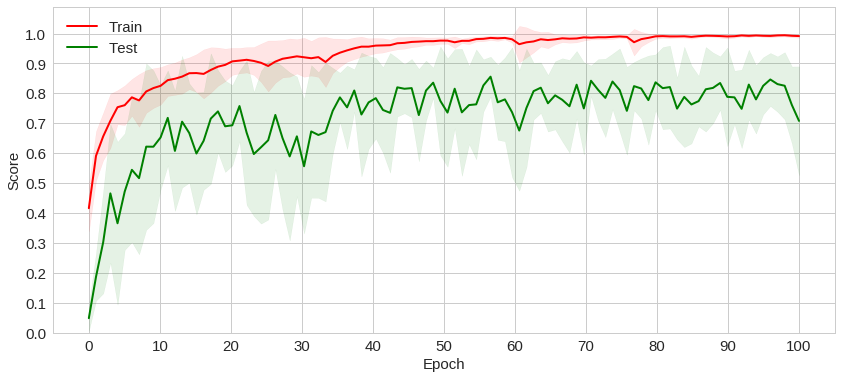

In [25]:
plot_mean_acc(history)

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, alpha=0.7, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-3.9,17.9))
    plt.show()

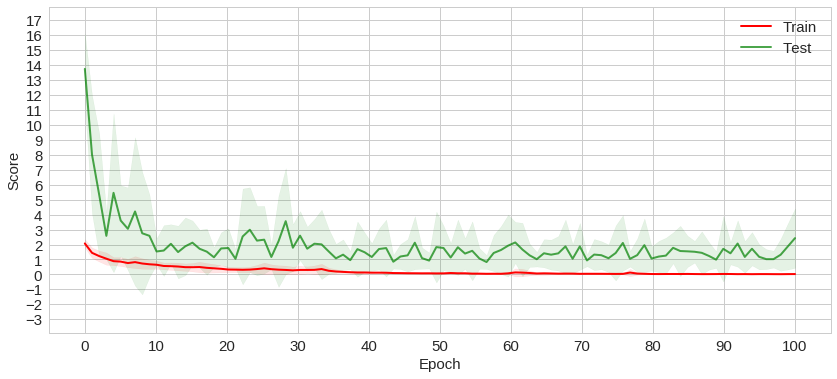

In [27]:
plot_mean_loss(history)